In [7]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from nero import Harmonia
import seaborn as sns
from matplotlib import cm
from matplotlib import colors

In [2]:
# merge clusters 
#adata.obs['louvain']=adata.obs['louvain'].where(adata.obs['louvain']!='CD14+ Mono2','CD14+ Mono')

In [86]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='leiden'):
    """A function go get mean z-score expressions of marker genes
    # 
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' """

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []
    
    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    #Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

In [113]:
adata_100k.var_names.to_dict()

AttributeError: 'Index' object has no attribute 'to_dict'

In [111]:
adata_100k.var_names

Index(['CD45', 'CD235', 'CD61', 'CD33', 'CD3', 'CD19', 'CD117', 'CD11b', 'CD4',
       'CD8a', 'CD11c', 'CD14', 'CD127', 'FCER1', 'CD123', 'gdTCR', 'CD45RA',
       'TIM3', 'PD-L1', 'CD27', 'CD45RO', 'CCR7', 'CD25', 'TCR_Va24_Ja18',
       'CD38', 'HLA_DR', 'PD-1', 'CD56'],
      dtype='object', name='Antibody')

In [108]:
test_dict = adata_100k.var_names

In [88]:
ptn_dict = ptn_names.to_dict()

In [99]:
adata_100k.var.columns.values

array([], dtype=object)

In [117]:
marker_gene_expression(adata_100k,marker_dict = 'Antibody',partition_key='leiden')

TypeError: string indices must be integers

# Make scanpy colors

In [8]:
vega_10 = list(map(colors.to_hex, cm.tab10.colors))
vega_10_scanpy = vega_10.copy()
vega_10_scanpy[2] = '#279e68'  # green
vega_10_scanpy[4] = '#aa40fc'  # purple
vega_10_scanpy[8] = '#b5bd61'  # kakhi

# default matplotlib 2.0 palette
# see 'category20' on https://github.com/vega/vega/wiki/Scales#scale-range-literals
vega_20 = list(map(colors.to_hex, cm.tab20.colors))
vega_20_scanpy = [
    *vega_20[0:14:2], *vega_20[16::2],  # dark without grey
    *vega_20[1:15:2], *vega_20[17::2],  # light without grey
    '#ad494a', '#8c6d31',  # manual additions
]
vega_20_scanpy[2] = vega_10_scanpy[2]
vega_20_scanpy[4] = vega_10_scanpy[4]
vega_20_scanpy[7] = vega_10_scanpy[8] 

In [ ]:
vega_20_scanpy

In [3]:
# might need this, the most recent version of jupterlab I installed installed the most recent version of jedi which has been having problems with autocomplete
# see thread here: https://github.com/ipython/ipython/issues/10493
%config Completer.use_jedi = False

sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [4]:
sc.set_figure_params(dpi_save=1000,figsize=[5,5])

In [125]:
demux_df = pd.read_table('100K_demux.allalpha.decimal.output.best.txt')

In [127]:
demux_df.shape[0]

35371

# 100k data

In [9]:
meta_df = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/100K_meta_ab_cell_matrix_dbc.txt',sep=',')
adt_df = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/100K_selected_ab_cell_matrix_dbc.txt',sep=',')           

In [10]:
meta_df.shape[0]

53644

In [11]:
meta_df.shape[0] - meta_df[meta_df['DBL_prob']<1E-9].shape[0] 

26155

In [12]:
filtered_meta_df = meta_df[(meta_df['DBL_prob']<1E-9)]

In [13]:
filtered_meta_df

orig.ident  nCount_RNA  nFeature_RNA    Batch     Type Demuxlet  \
X22       SeuratProject        1610            24   Batch1  Doublet   donor0   
X40       SeuratProject        1153            27   Batch1  Singlet   donor1   
X46       SeuratProject        1523            25   Batch1  Singlet   donor1   
X54       SeuratProject        1296            26   Batch1  Singlet   donor0   
X65       SeuratProject         759            21   Batch1  Doublet   donor1   
...                 ...         ...           ...      ...      ...      ...   
X34241.1  SeuratProject         701            20  Batch10  Doublet   donor0   
X34246.1  SeuratProject         549            14  Batch10  Doublet   donor0   
X34252    SeuratProject        1064            22  Batch10  Singlet   donor0   
X34265    SeuratProject         447            14  Batch10  Singlet   donor1   
X34286    SeuratProject        1007            20  Batch10  Singlet   donor0   

                    DBC_real      DBL_prob    SNG_d1_prob    SNG_d0_prob  \
X22       AAACCCAGTGGTTTGT-1  3.500000e-48   0.000000e+00   1.000000e+00   
X40       AAACGAAAGGTAGATT-1  5.760000e-17   1.000000e+00   1.050000e-90   
X46       AAACGAACAAGGCGTA-1  8.240000e-14   1.000000e+00   4.770000e-89   
X54       AAACGAAGTAGGGAGG-1  3.990000e-42  1.690000e-299   1.000000e+00   
X65       AAACGAATCTAGCCAA-1  2.470000e-36   1.000000e+00  9.240000e-237   
...                      ...           ...            ...            ...   
X34241.1  TTTGGTTTCATCACAG-1  5.210000e-41  4.700000e-287   1.000000e+00   
X34246.1  TTTGGTTTCGGTCAGC-1  7.150000e-26  4.200000e-182   1.000000e+00   
X34252    TTTGTTGAGGGAGATA-1  8.110000e-21  2.280000e-138   1.000000e+00   
X34265    TTTGTTGCAGCTTTGA-1  6.430000e-13   1.000000e+00   2.610000e-74   
X34286    TTTGTTGTCTACCCAC-1  7.250000e-25  3.120000e-178   1.000000e+00   

          nCount_ADT  nFeature_ADT  
X22             1610            24  
X40             1153            27  
X46             1523            25  
X54             1296            26  
X65              759            21  
...              ...           ...  
X34241.1         701            20  
X34246.1         549            14  
X34252          1064            22  
X34265           447            14  
X34286          1007            20  

[27489 rows x 12 columns]

In [34]:
meta_df_2 = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/100K_meta_ab_cell_matrix-2.txt',sep=',')
adt_df_2 = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/100K_selected_ab_cell_matrix-2.txt' ,sep=',')           

In [35]:
meta_df_2.shape

(53644, 9)

In [17]:
meta_df.shape

(53644, 10)

In [18]:
adt_df.shape

(28, 53644)

In [14]:
filtered_adt_df = adt_df.T.filter(items=filtered_meta_df.index, axis = 'index')

In [30]:
meta_df[((meta_df['Demuxlet']=='donor0')|(meta_df['Demuxlet']=='donor1'))].shape[0]

33985

In [31]:
meta_df[meta_df['Type']=='Singlet'].shape[0]

19171

In [27]:
meta_df[meta_df['Droptype']=='singlet'].shape[0]

27491

In [38]:
meta_df_2[meta_df_2['Type']=='Singlet'].shape[0]

19171

In [249]:
adt_df.T.head()

1   2   3   4    5   6   7    8   9    10  ...  19   20   21  22  23  \
X14  537   2   9   4   12   3   3  391  29    1  ...   7    4  175  20   2   
X22  389   5  84   0    7   0   0  469  16    3  ...   5    2  214   8   5   
X40  298   1   3   2    5   1   2  308  15    5  ...   2    3   79   6   3   
X46  345   1   2   0  181   1   0    4   1  364  ...   3  133   10   8   2   
X49  356   4   3   2    8   3   1  296  15    8  ...   0    1   72   8   1   

     24  25  26  27  28  
X14   2  65  97   1   3  
X22   2  56  34   2   3  
X40   3  21  11   1   2  
X46   1  11   2   4   2  
X49   2  28  25   1   3  

[5 rows x 28 columns]

In [15]:
adt_from_R_adata = sc.AnnData(filtered_adt_df)
adt_from_R_adata.obs = filtered_meta_df
adt_from_R_adata.obs

sc.pp.normalize_per_cell(adt_from_R_adata, counts_per_cell_after=1e4)

Transforming to str index.
/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:653: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[key_n_counts] = counts_per_cell


In [16]:
adt_from_R_adata.obs

orig.ident  nCount_RNA  nFeature_RNA    Batch     Type Demuxlet  \
X22       SeuratProject        1610            24   Batch1  Doublet   donor0   
X40       SeuratProject        1153            27   Batch1  Singlet   donor1   
X46       SeuratProject        1523            25   Batch1  Singlet   donor1   
X54       SeuratProject        1296            26   Batch1  Singlet   donor0   
X65       SeuratProject         759            21   Batch1  Doublet   donor1   
...                 ...         ...           ...      ...      ...      ...   
X34241.1  SeuratProject         701            20  Batch10  Doublet   donor0   
X34246.1  SeuratProject         549            14  Batch10  Doublet   donor0   
X34252    SeuratProject        1064            22  Batch10  Singlet   donor0   
X34265    SeuratProject         447            14  Batch10  Singlet   donor1   
X34286    SeuratProject        1007            20  Batch10  Singlet   donor0   

                    DBC_real      DBL_prob    SNG_d1_prob    SNG_d0_prob  \
X22       AAACCCAGTGGTTTGT-1  3.500000e-48   0.000000e+00   1.000000e+00   
X40       AAACGAAAGGTAGATT-1  5.760000e-17   1.000000e+00   1.050000e-90   
X46       AAACGAACAAGGCGTA-1  8.240000e-14   1.000000e+00   4.770000e-89   
X54       AAACGAAGTAGGGAGG-1  3.990000e-42  1.690000e-299   1.000000e+00   
X65       AAACGAATCTAGCCAA-1  2.470000e-36   1.000000e+00  9.240000e-237   
...                      ...           ...            ...            ...   
X34241.1  TTTGGTTTCATCACAG-1  5.210000e-41  4.700000e-287   1.000000e+00   
X34246.1  TTTGGTTTCGGTCAGC-1  7.150000e-26  4.200000e-182   1.000000e+00   
X34252    TTTGTTGAGGGAGATA-1  8.110000e-21  2.280000e-138   1.000000e+00   
X34265    TTTGTTGCAGCTTTGA-1  6.430000e-13   1.000000e+00   2.610000e-74   
X34286    TTTGTTGTCTACCCAC-1  7.250000e-25  3.120000e-178   1.000000e+00   

          nCount_ADT  nFeature_ADT  n_counts  
X22             1610            24    1610.0  
X40             1153            27    1153.0  
X46             1523            25    1523.0  
X54             1296            26    1296.0  
X65              759            21     759.0  
...              ...           ...       ...  
X34241.1         701            20     701.0  
X34246.1         549            14     549.0  
X34252          1064            22    1064.0  
X34265           447            14     447.0  
X34286          1007            20    1007.0  

[27489 rows x 13 columns]

In [17]:
batch1 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch1']
batch2 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch2']
batch3 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch3']
batch4 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch4']
batch5 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch5']
batch6 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch6']
batch7 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch7']
batch8 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch8']
batch9 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch9']
batch10 = adt_from_R_adata[adt_from_R_adata.obs['Batch']=='Batch10']

sc.pp.log1p(batch1)
sc.pp.log1p(batch2)
sc.pp.log1p(batch3)
sc.pp.log1p(batch4)
sc.pp.log1p(batch5)
sc.pp.log1p(batch6)
sc.pp.log1p(batch7)
sc.pp.log1p(batch8)
sc.pp.log1p(batch9)
sc.pp.log1p(batch10)

sc.pp.scale(batch1, max_value=10)
sc.pp.scale(batch2, max_value=10)
sc.pp.scale(batch3, max_value=10)
sc.pp.scale(batch4, max_value=10)
sc.pp.scale(batch5, max_value=10)
sc.pp.scale(batch6, max_value=10)
sc.pp.scale(batch7, max_value=10)
sc.pp.scale(batch8, max_value=10)
sc.pp.scale(batch9, max_value=10)
sc.pp.scale(batch10, max_value=10)

per_batch_norm_from_R_adata = batch1.concatenate(batch2,batch3,batch4,batch5,batch6,batch7,batch8,batch9,batch10)

/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [18]:
per_batch_norm_from_R_adata.var_names_make_unique()

In [19]:
ptn_names =pd.DataFrame(['CD45','CD235','CD61','CD33','CD3','CD19','CD117','CD11b','CD4','CD8a','CD11c','CD14','CD127', 'FCER1','CD123','gdTCR', 'CD45RA','TIM3','PD-L1','CD27','CD45RO','CCR7','CD25','TCR_Va24_Ja18','CD38', 'HLA_DR','PD-1','CD56'])

ptn_names.columns=['Antibody']
ptn_names = ptn_names.set_index('Antibody')

per_batch_norm_from_R_adata.var = ptn_names

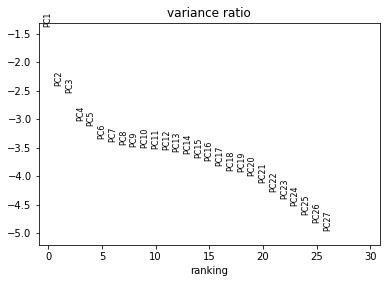

In [20]:
sc.tl.pca(per_batch_norm_from_R_adata, svd_solver='arpack', use_highly_variable=None)
sc.pl.pca_variance_ratio(per_batch_norm_from_R_adata, log=True)

# 200K

In [255]:
meta_2_df = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/200K_meta_ab_cell_matrix-2.txt',sep=',')
adt_2_df = pd.read_table('/wynton/group/ye/david/Cyto-seq/200204/200K_selected_ab_cell_matrix-2.txt',sep=',')           

In [256]:
adt_from_R_adata_2 = sc.AnnData(adt_2_df.T)
adt_from_R_adata_2.obs = meta_2_df
adt_from_R_adata_2.obs

sc.pp.normalize_per_cell(adt_from_R_adata_2, counts_per_cell_after=1e4)

Transforming to str index.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [257]:
batch1 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch1']
batch2 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch2']
batch3 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch3']
batch4 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch4']
batch5 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch5']
batch6 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch6']
batch7 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch7']
batch8 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch8']
batch9 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch9']
batch10 = adt_from_R_adata_2[adt_from_R_adata_2.obs['Batch']=='Batch10']

sc.pp.log1p(batch1)
sc.pp.log1p(batch2)
sc.pp.log1p(batch3)
sc.pp.log1p(batch4)
sc.pp.log1p(batch5)
sc.pp.log1p(batch6)
sc.pp.log1p(batch7)
sc.pp.log1p(batch8)
sc.pp.log1p(batch9)
sc.pp.log1p(batch10)

sc.pp.scale(batch1, max_value=10)
sc.pp.scale(batch2, max_value=10)
sc.pp.scale(batch3, max_value=10)
sc.pp.scale(batch4, max_value=10)
sc.pp.scale(batch5, max_value=10)
sc.pp.scale(batch6, max_value=10)
sc.pp.scale(batch7, max_value=10)
sc.pp.scale(batch8, max_value=10)
sc.pp.scale(batch9, max_value=10)
sc.pp.scale(batch10, max_value=10)

per_batch_norm_from_R_adata_2 = batch1.concatenate(batch2,batch3,batch4,batch5,batch6,batch7,batch8,batch9,batch10)

/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10
    ... clipping at max_value 10


In [258]:
per_batch_norm_from_R_adata_2.var_names_make_unique()

In [259]:
ptn_names =pd.DataFrame(['CD45','CD235','CD61','CD33','CD3','CD19','CD117','CD11b','CD4','CD8a','CD11c','CD14','CD127', 'FCER1','CD123','gdTCR', 'CD45RA','TIM3','PD-L1','CD27','CD45RO','CCR7','CD25','TCR_Va24_Ja18','CD38', 'HLA_DR','PD-1','CD56'])

ptn_names.columns=['Antibody']
ptn_names = ptn_names.set_index('Antibody')

per_batch_norm_from_R_adata_2.var = ptn_names

computing PCA with n_comps = 50
    reducing number of computed PCs to 27 as dim of data is only 28
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


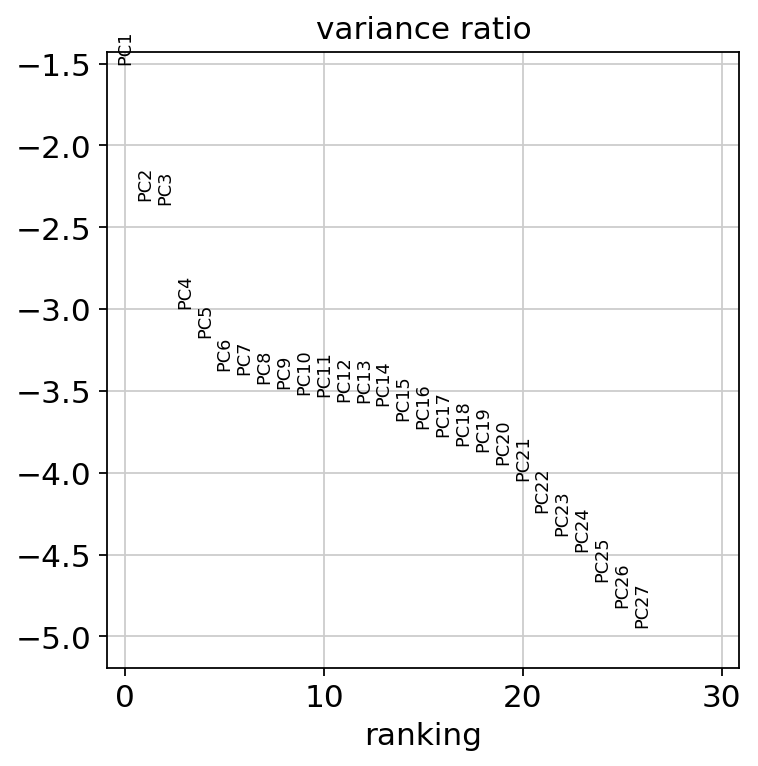

In [260]:
sc.tl.pca(per_batch_norm_from_R_adata_2, svd_solver='arpack', use_highly_variable=None)
sc.pl.pca_variance_ratio(per_batch_norm_from_R_adata_2, log=True)

In [21]:
adata_100k = per_batch_norm_from_R_adata[(per_batch_norm_from_R_adata.obs['Demuxlet']== 'donor0')|(per_batch_norm_from_R_adata.obs['Demuxlet']== 'donor1')]
#adata_200k = per_batch_norm_from_R_adata_2[(per_batch_norm_from_R_adata_2.obs['Demuxlet']== 'donor0')|(per_batch_norm_from_R_adata_2.obs['Demuxlet']== 'donor1')]

In [77]:
gen_sng_100k = per_batch_norm_from_R_adata[(per_batch_norm_from_R_adata.obs['Demuxlet']== 'donor0')|(per_batch_norm_from_R_adata.obs['Demuxlet']== 'donor1')]
gen_dbl_100k = per_batch_norm_from_R_adata[(per_batch_norm_from_R_adata.obs['Demuxlet']== 'donor0,donor1')]

In [329]:
gen_sng_200k = per_batch_norm_from_R_adata_2[(per_batch_norm_from_R_adata_2.obs['Demuxlet']== 'donor0')|(per_batch_norm_from_R_adata_2.obs['Demuxlet']== 'donor1')]
gen_dbl_200k = per_batch_norm_from_R_adata_2[(per_batch_norm_from_R_adata_2.obs['Demuxlet']== 'donor0,donor1')]

In [22]:
singlets_100k = per_batch_norm_from_R_adata[per_batch_norm_from_R_adata.obs['Type']=='Singlet']
#singlets_200k = per_batch_norm_from_R_adata_2[per_batch_norm_from_R_adata_2.obs['Type']=='Singlet']

In [23]:
singlets_100k.obs.shape[0]

13387

In [24]:
singlets_200k.obs.shape[0]

NameError: name 'singlets_200k' is not defined

In [25]:
multiplets_100k = per_batch_norm_from_R_adata[per_batch_norm_from_R_adata.obs['Type']=='Doublet']
#multiplets_200k = per_batch_norm_from_R_adata_2[per_batch_norm_from_R_adata_2.obs['Type']=='Doublet']

In [98]:
multiplets_100k.obs.shape[0]

14102

In [267]:
multiplets_200k.obs.shape[0]

75000

In [26]:
sc.tl.pca(adata_100k, svd_solver='arpack', use_highly_variable=None)
sc.pp.neighbors(adata_100k, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata_100k)
sc.tl.leiden(adata_100k)

/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/ye/davidslee/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../ho

In [269]:
sc.tl.pca(adata_200k, svd_solver='arpack', use_highly_variable=None)
sc.pp.neighbors(adata_200k, n_neighbors=10, n_pcs=15)
sc.tl.umap(adata_200k)
sc.tl.leiden(adata_200k)

computing PCA with n_comps = 50
    reducing number of computed PCs to 27 as dim of data is only 28
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using data matrix X directly


/wynton/home/ye/davidslee/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/ye/davidslee/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    computed neighbors (0:00:06)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:42)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)


... storing 'Batch' as categorical
... storing 'Demuxlet' as categorical
... storing 'Type' as categorical
... storing 'orig.ident' as categorical


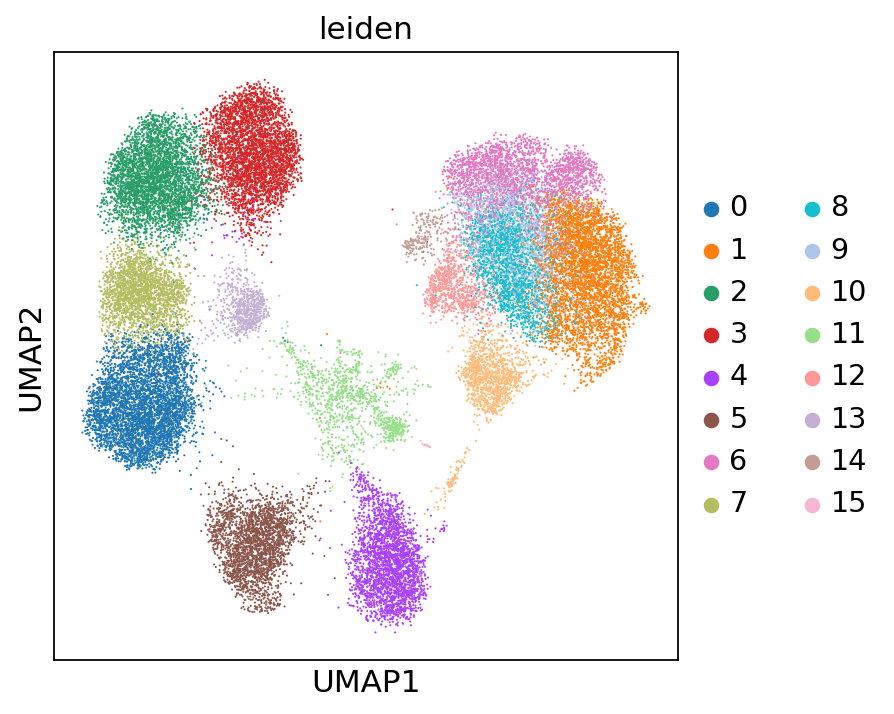

In [270]:
sc.pl.umap(adata_100k, color = 'leiden')

... storing 'Batch' as categorical
... storing 'DBC_real' as categorical
... storing 'Demuxlet' as categorical
... storing 'Type' as categorical
... storing 'orig.ident' as categorical


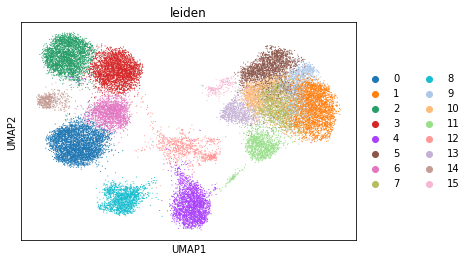

In [82]:
sc.pl.umap(adata_100k, color = 'leiden')

... storing 'Batch' as categorical
... storing 'Demuxlet' as categorical
... storing 'Type' as categorical
... storing 'orig.ident' as categorical


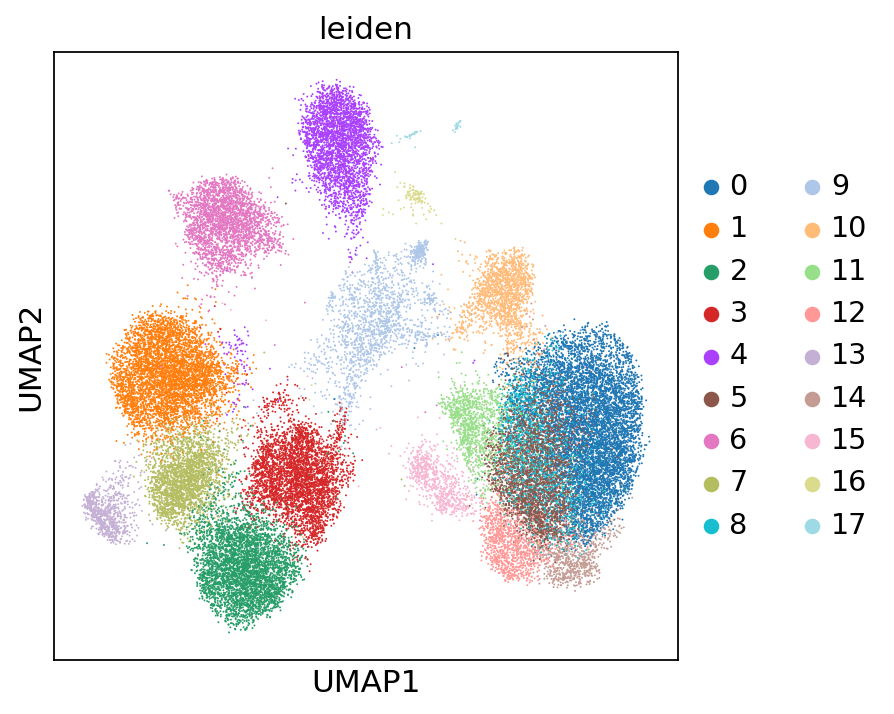

In [271]:
sc.pl.umap(adata_200k, color = 'leiden')

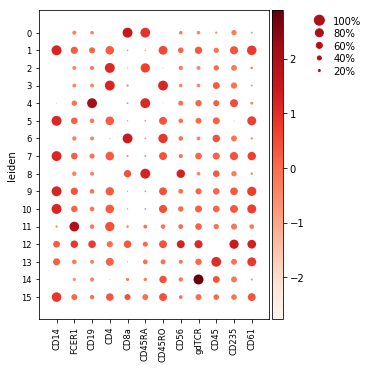

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [83]:
sc.pl.dotplot(adata_100k, groupby = 'leiden', var_names = ['CD14', 'FCER1','CD19','CD4','CD8a', 'CD45RA','CD45RO','CD56','gdTCR','CD45','CD235','CD61'])


In [273]:
new_cluster_names = ['CD8 Naïve T cells',
'Monocytes',
'CD4 Naïve T cells',
'CD4 Memory T cells',
'B cells',
'Monocytes-2',
'CD8 Memory T cells',
'Monocytes-3',
'Natural Killer cells',
'Monocytes-4',
'Monocytes-5',
'Conventional Dendritic cells',
'Collided cells',
'Collided cells-2',
'gd T cells',
'RBCs'
]
adata_100k.rename_categories('leiden', new_cluster_names)

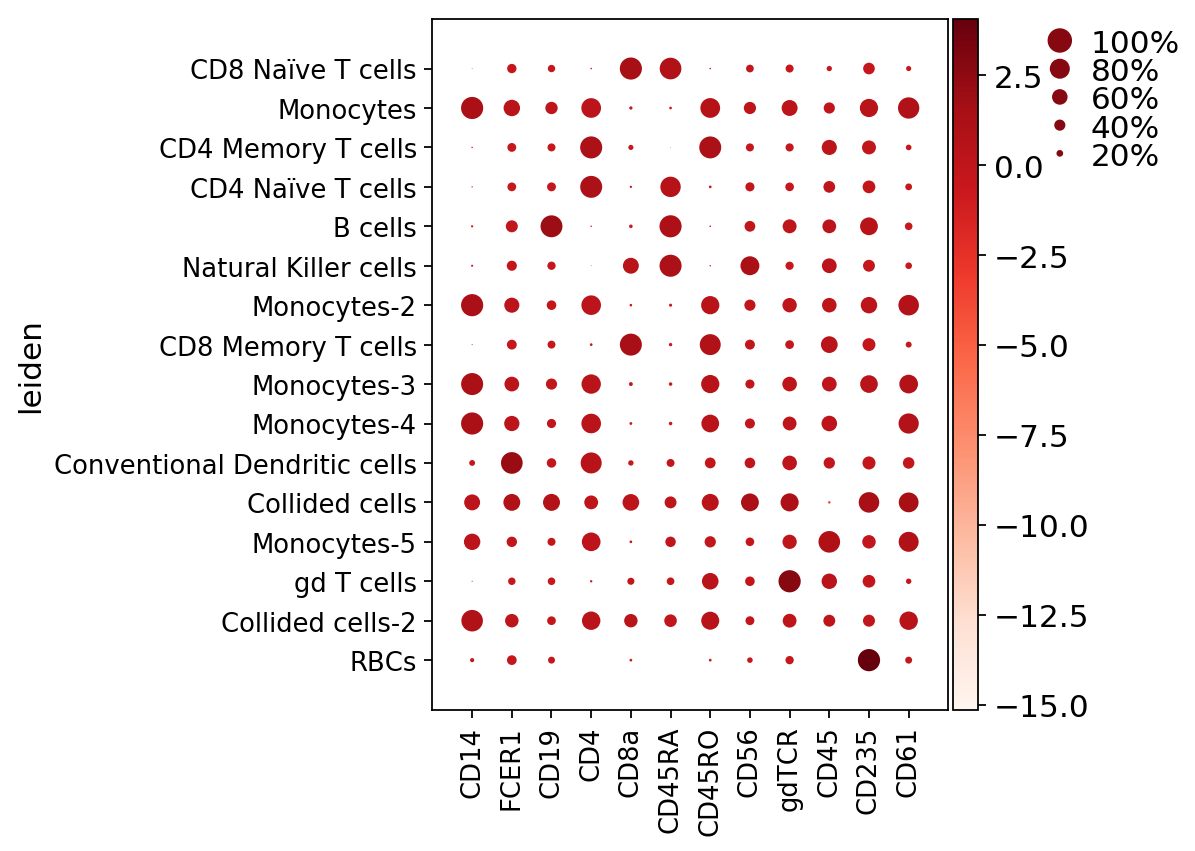

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [274]:
sc.pl.dotplot(adata_100k, groupby = 'leiden', var_names = ['CD14', 'FCER1','CD19','CD4','CD8a', 'CD45RA','CD45RO','CD56','gdTCR','CD45','CD235','CD61'])


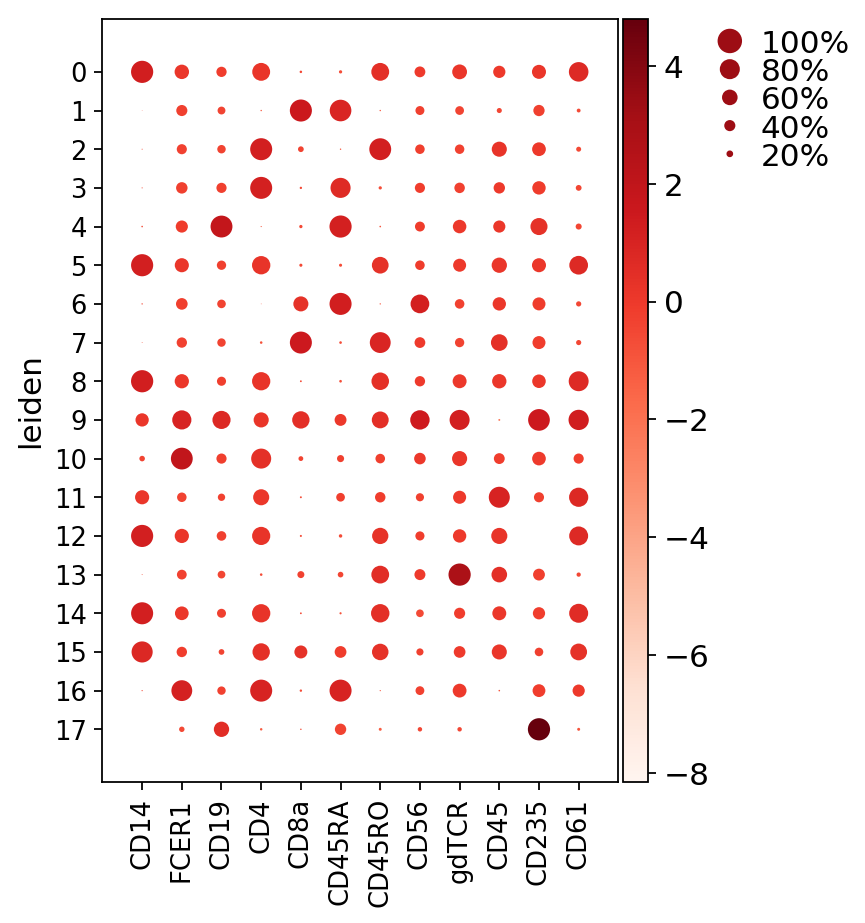

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [275]:
sc.pl.dotplot(adata_200k, groupby = 'leiden', var_names = ['CD14', 'FCER1','CD19','CD4','CD8a', 'CD45RA','CD45RO','CD56','gdTCR','CD45','CD235','CD61'])


In [276]:
new_cluster_names = ['Monocytes','CD8 Naïve T cells','CD4 Memory T cells','CD4 Naïve T cells','B cells','Monocytes-2',
                     'Natural Killer cells','CD8 Memory T cells','Monocytes-3','Collided cells',
                     'Conventional Dendritic cells','Monocytes-4','Monocytes-5','gd T cells','Monocytes-6','Collided cells-2',
                     'Collided cells-3','RBCs']

adata_200k.rename_categories('leiden', new_cluster_names)

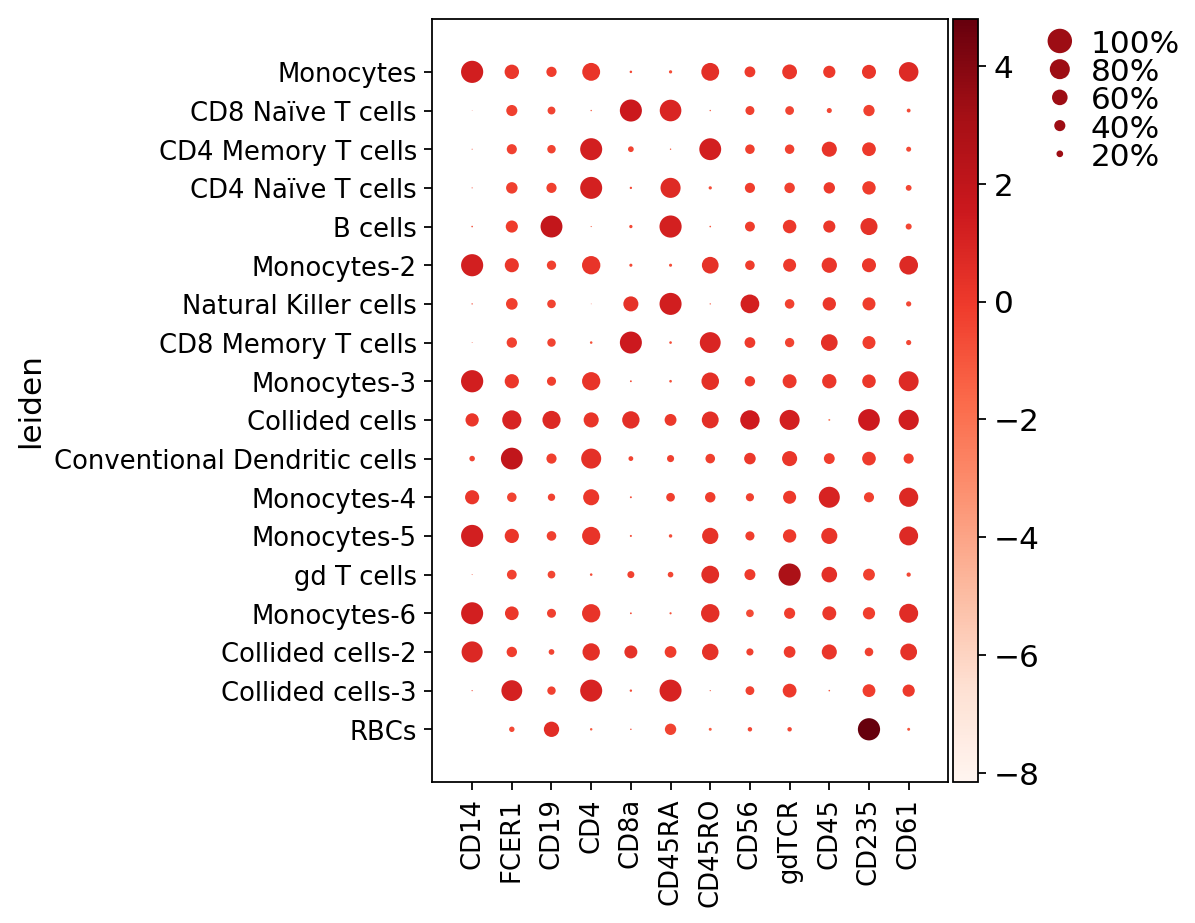

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[4.199999999999999, 0, 0.2, 0.5, 0.25])

In [277]:
sc.pl.dotplot(adata_200k, groupby = 'leiden', var_names = ['CD14', 'FCER1','CD19','CD4','CD8a', 'CD45RA','CD45RO','CD56','gdTCR','CD45','CD235','CD61'])


In [116]:
new_cluster_names = ['0','1','2','3','4','5',
                     '6','7','8','9',
                     '10','11','12','13','14','15']

adata_100k.rename_categories('leiden', new_cluster_names)

In [282]:
new_cluster_names = ['0','1','2','3','4','5',
                     '6','7','8','9',
                     '10','11','12','13','14','15',
                     '16','17']

adata_200k.rename_categories('leiden', new_cluster_names)

In [27]:
#all clusters
donor0_100k_all_clusters = adata_100k[adata_100k.obs['Demuxlet']== 'donor0']
donor1_100k_all_clusters = adata_100k[adata_100k.obs['Demuxlet']== 'donor1']

donor0_100k_sng =donor0_100k_all_clusters[donor0_100k_all_clusters.obs['Type']== 'Singlet']
donor1_100k_sng =donor1_100k_all_clusters[donor1_100k_all_clusters.obs['Type']== 'Singlet']

donor0_100k_mpl =donor0_100k_all_clusters[donor0_100k_all_clusters.obs['Type']== 'Doublet']
donor1_100k_mpl =donor1_100k_all_clusters[donor1_100k_all_clusters.obs['Type']== 'Doublet']

In [34]:
donor0_100k_all_clusters

View of AnnData object with n_obs × n_vars = 13864 × 28 
    obs: 'Batch', 'DBC_real', 'DBL_prob', 'Demuxlet', 'SNG_d0_prob', 'SNG_d1_prob', 'Type', 'batch', 'nCount_ADT', 'nCount_RNA', 'nFeature_ADT', 'nFeature_RNA', 'n_counts', 'orig.ident', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [28]:
donor0_100k_sng.obs.shape[0]+donor1_100k_sng.obs.shape[0]

13387

In [40]:
donor0_100k_all_clusters.obs.index

Index(['X22-0', 'X54-0', 'X67-0', 'X99-0', 'X108-0', 'X131-0', 'X132-0',
       'X145-0', 'X149-0', 'X156-0',
       ...
       'X34133-9', 'X34146-9', 'X34161-9', 'X34176.2-9', 'X34187.1-9',
       'X34211.1-9', 'X34241.1-9', 'X34246.1-9', 'X34252-9', 'X34286-9'],
      dtype='object', length=13864)

In [64]:
sub1_inds = np.random.choice(donor0_100k_all_clusters.obs.index, size = 13684)
subset1 = donor0_100k_all_clusters[sub1_inds[0:8000],:]
subset2 = donor0_100k_all_clusters[sub1_inds[8001:],:]

In [74]:
sub1_inds = np.random.choice(donor1_100k_all_clusters.obs.index, size = 13684)
subset1_d1 = donor1_100k_all_clusters[sub1_inds[0:8000],:]
subset2_d1 = donor1_100k_all_clusters[sub1_inds[8001:],:]

In [75]:
stats.pearsonr(subset1, subset1_d1)

KeyboardInterrupt: 

In [65]:
subset1.obs

Batch            DBC_real      DBL_prob Demuxlet  SNG_d0_prob  \
X29613-1     Batch2  TGACTCCAGATTGCGG-1  9.790000e-19   donor0          1.0   
X13007-1     Batch2  CGCAGGTGTATCGGTT-1  2.000000e-27   donor0          1.0   
X22571-2     Batch3  GTCACGGAGGCCTGAA-1  2.390000e-18   donor0          1.0   
X206.2-7     Batch8  AAAGGTAAGTCAGGGT-1  1.430000e-61   donor0          1.0   
X32824-1     Batch2  TTCCTTCGTACCTAAC-1  4.100000e-22   donor0          1.0   
...             ...                 ...           ...      ...          ...   
X21589.1-2   Batch3  GGTAGAGTCGGCTTCT-1  3.340000e-16   donor0          1.0   
X14245.1-9  Batch10  CTACGGGCAAGCTCTA-1  4.660000e-28   donor0          1.0   
X11335-2     Batch3  CCCGAAGAGGGAGATA-1  3.560000e-12   donor0          1.0   
X10930-4     Batch5  CCAATTTGTCGGTACC-1  7.030000e-20   donor0          1.0   
X23445-5     Batch6  GTGCGTGGTAGTATAG-1  3.100000e-42   donor0          1.0   

              SNG_d1_prob     Type batch  nCount_ADT  nCount_RNA  \
X29613-1    6.890000e-141  Singlet     1        1959        1959   
X13007-1    1.510000e-216  Doublet     1        2464        2464   
X22571-2    1.800000e-142  Singlet     2        1796        1796   
X206.2-7     0.000000e+00  Doublet     7        1011        1011   
X32824-1    1.990000e-185  Singlet     1        1468        1468   
...                   ...      ...   ...         ...         ...   
X21589.1-2  1.850000e-103  Doublet     2        1027        1027   
X14245.1-9  2.600000e-212  Doublet     9         593         593   
X11335-2     8.100000e-93  Singlet     2        1834        1834   
X10930-4    5.710000e-174  Singlet     4         428         428   
X23445-5     0.000000e+00  Singlet     5         947         947   

            nFeature_ADT  nFeature_RNA  n_counts     orig.ident leiden  
X29613-1              28            28    1959.0  SeuratProject      1  
X13007-1              27            27    2464.0  SeuratProject     10  
X22571-2              25            25    1796.0  SeuratProject     10  
X206.2-7              26            26    1011.0  SeuratProject      1  
X32824-1              27            27    1468.0  SeuratProject      1  
...                  ...           ...       ...            ...    ...  
X21589.1-2            24            24    1027.0  SeuratProject      6  
X14245.1-9            18            18     593.0  SeuratProject      5  
X11335-2              23            23    1834.0  SeuratProject      9  
X10930-4              25            25     428.0  SeuratProject      9  
X23445-5              23            23     947.0  SeuratProject     11  

[8000 rows x 15 columns]

In [66]:
subset2.obs

Batch            DBC_real      DBL_prob Demuxlet  SNG_d0_prob  \
X31055.1-9  Batch10  TGGGCTGTCCTAAGTG-1  8.610000e-18   donor0          1.0   
X12013-0     Batch1  CCTAAGAGTTGTGCAT-1  1.840000e-29   donor0          1.0   
X6379-8      Batch9  ATCACAGCACAACCGC-1  3.680000e-17   donor0          1.0   
X13069-5     Batch6  CGCATGGAGGACTGGT-1  1.550000e-22   donor0          1.0   
X19130-1     Batch2  GCATCTCTCCCGAAAT-1  1.600000e-30   donor0          1.0   
...             ...                 ...           ...      ...          ...   
X4679-9     Batch10  AGCGTATAGTGCCAGA-1  3.810000e-14   donor0          1.0   
X30850-4     Batch5  TGGCGTGAGACCATTC-1  1.670000e-56   donor0          1.0   
X9622.1-7    Batch8  CAGCGTGAGACAGCGT-1  4.290000e-20   donor0          1.0   
X394-9      Batch10  AACAACCAGGTGCTGA-1  4.030000e-24   donor0          1.0   
X7906-0      Batch1  ATTCGTTCATTGAAGA-1  7.180000e-31   donor0          1.0   

              SNG_d1_prob     Type batch  nCount_ADT  nCount_RNA  \
X31055.1-9  1.410000e-107  Doublet     9        1364        1364   
X12013-0    1.690000e-281  Doublet     0         888         888   
X6379-8     3.390000e-125  Singlet     8        1975        1975   
X13069-5    4.220000e-210  Singlet     5         557         557   
X19130-1    2.830000e-223  Doublet     1        1932        1932   
...                   ...      ...   ...         ...         ...   
X4679-9      1.510000e-93  Singlet     9        1158        1158   
X30850-4     0.000000e+00  Doublet     4        1051        1051   
X9622.1-7   3.240000e-130  Doublet     7         844         844   
X394-9      8.590000e-179  Singlet     9        1004        1004   
X7906-0     5.340000e-240  Doublet     0        1375        1375   

            nFeature_ADT  nFeature_RNA  n_counts     orig.ident leiden  
X31055.1-9            18            18    1364.0  SeuratProject      3  
X12013-0              22            22     888.0  SeuratProject      5  
X6379-8               23            23    1975.0  SeuratProject      5  
X13069-5              23            23     557.0  SeuratProject     11  
X19130-1              26            26    1932.0  SeuratProject      1  
...                  ...           ...       ...            ...    ...  
X4679-9               17            17    1158.0  SeuratProject      8  
X30850-4              27            27    1051.0  SeuratProject      1  
X9622.1-7             21            21     844.0  SeuratProject      2  
X394-9                17            17    1004.0  SeuratProject      7  
X7906-0               24            24    1375.0  SeuratProject     15  

[5683 rows x 15 columns]

In [67]:
#donor0 100k_all_clusters subset 1
c0 = subset1[(subset1.obs['leiden']=='0')].shape[0]/(subset1.obs.shape[0])
c1 = subset1[(subset1.obs['leiden']=='1')].shape[0]/subset1.obs.shape[0]
c2 = subset1[(subset1.obs['leiden']=='2')].shape[0]/subset1.obs.shape[0]
c3 = subset1[(subset1.obs['leiden']=='3')].shape[0]/subset1.obs.shape[0]
c4 = subset1[(subset1.obs['leiden']=='4')].shape[0]/subset1.obs.shape[0]
c5 = subset1[(subset1.obs['leiden']=='5') ].shape[0]/subset1.obs.shape[0]
c6 = subset1[(subset1.obs['leiden']=='6')].shape[0]/subset1.obs.shape[0]
c7 = subset1[(subset1.obs['leiden']=='7')].shape[0]/subset1.obs.shape[0]
c8 = subset1[(subset1.obs['leiden']=='8')].shape[0]/subset1.obs.shape[0]
c9 = subset1[(subset1.obs['leiden']=='9')].shape[0]/subset1.obs.shape[0]
c10 = subset1[(subset1.obs['leiden']=='10')].shape[0]/subset1.obs.shape[0]
c11 = subset1[(subset1.obs['leiden']=='11')].shape[0]/subset1.obs.shape[0]
c12 = subset1[(subset1.obs['leiden']=='12')].shape[0]/subset1.obs.shape[0]
c13 = subset1[(subset1.obs['leiden']=='13')].shape[0]/subset1.obs.shape[0]
c14 = subset1[(subset1.obs['leiden']=='14')].shape[0]/subset1.obs.shape[0]
c15 = subset1[(subset1.obs['leiden']=='15')].shape[0]/subset1.obs.shape[0]

subset1_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(subset1_proportions)




#donor0 100k_all_clusters subset 2
c0 = subset2[(subset2.obs['leiden']=='0')].shape[0]/(subset2.obs.shape[0])
c1 = subset2[(subset2.obs['leiden']=='1')].shape[0]/subset2.obs.shape[0]
c2 = subset2[(subset2.obs['leiden']=='2')].shape[0]/subset2.obs.shape[0]
c3 = subset2[(subset2.obs['leiden']=='3')].shape[0]/subset2.obs.shape[0]
c4 = subset2[(subset2.obs['leiden']=='4')].shape[0]/subset2.obs.shape[0]
c5 = subset2[(subset2.obs['leiden']=='5') ].shape[0]/subset2.obs.shape[0]
c6 = subset2[(subset2.obs['leiden']=='6')].shape[0]/subset2.obs.shape[0]
c7 = subset2[(subset2.obs['leiden']=='7')].shape[0]/subset2.obs.shape[0]
c8 = subset2[(subset2.obs['leiden']=='8')].shape[0]/subset2.obs.shape[0]
c9 = subset2[(subset2.obs['leiden']=='9')].shape[0]/subset2.obs.shape[0]
c10 = subset2[(subset2.obs['leiden']=='10')].shape[0]/subset2.obs.shape[0]
c11 = subset2[(subset2.obs['leiden']=='11')].shape[0]/subset2.obs.shape[0]
c12 = subset2[(subset2.obs['leiden']=='12')].shape[0]/subset2.obs.shape[0]
c13 = subset2[(subset2.obs['leiden']=='13')].shape[0]/subset2.obs.shape[0]
c14 = subset2[(subset2.obs['leiden']=='14')].shape[0]/subset2.obs.shape[0]
c15 = subset2[(subset2.obs['leiden']=='15')].shape[0]/subset2.obs.shape[0]

subset2_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]


np.sum(subset2_proportions)




1.0

In [76]:
#donor0 100k_all_clusters subset 1
c0 = subset1_d1[(subset1_d1.obs['leiden']=='0')].shape[0]/(subset1_d1.obs.shape[0])
c1 = subset1_d1[(subset1_d1.obs['leiden']=='1')].shape[0]/subset1_d1.obs.shape[0]
c2 = subset1_d1[(subset1_d1.obs['leiden']=='2')].shape[0]/subset1_d1.obs.shape[0]
c3 = subset1_d1[(subset1_d1.obs['leiden']=='3')].shape[0]/subset1_d1.obs.shape[0]
c4 = subset1_d1[(subset1_d1.obs['leiden']=='4')].shape[0]/subset1_d1.obs.shape[0]
c5 = subset1_d1[(subset1_d1.obs['leiden']=='5') ].shape[0]/subset1_d1.obs.shape[0]
c6 = subset1_d1[(subset1_d1.obs['leiden']=='6')].shape[0]/subset1_d1.obs.shape[0]
c7 = subset1_d1[(subset1_d1.obs['leiden']=='7')].shape[0]/subset1_d1.obs.shape[0]
c8 = subset1_d1[(subset1_d1.obs['leiden']=='8')].shape[0]/subset1_d1.obs.shape[0]
c9 = subset1_d1[(subset1_d1.obs['leiden']=='9')].shape[0]/subset1_d1.obs.shape[0]
c10 = subset1_d1[(subset1_d1.obs['leiden']=='10')].shape[0]/subset1_d1.obs.shape[0]
c11 = subset1_d1[(subset1_d1.obs['leiden']=='11')].shape[0]/subset1_d1.obs.shape[0]
c12 = subset1_d1[(subset1_d1.obs['leiden']=='12')].shape[0]/subset1_d1.obs.shape[0]
c13 = subset1_d1[(subset1_d1.obs['leiden']=='13')].shape[0]/subset1_d1.obs.shape[0]
c14 = subset1_d1[(subset1_d1.obs['leiden']=='14')].shape[0]/subset1_d1.obs.shape[0]
c15 = subset1_d1[(subset1_d1.obs['leiden']=='15')].shape[0]/subset1_d1.obs.shape[0]

subset1_d1_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(subset1_d1_proportions)




#donor0 100k_all_clusters subset 2
c0 = subset2_d1[(subset2_d1.obs['leiden']=='0')].shape[0]/(subset2_d1.obs.shape[0])
c1 = subset2_d1[(subset2_d1.obs['leiden']=='1')].shape[0]/subset2_d1.obs.shape[0]
c2 = subset2_d1[(subset2_d1.obs['leiden']=='2')].shape[0]/subset2_d1.obs.shape[0]
c3 = subset2_d1[(subset2_d1.obs['leiden']=='3')].shape[0]/subset2_d1.obs.shape[0]
c4 = subset2_d1[(subset2_d1.obs['leiden']=='4')].shape[0]/subset2_d1.obs.shape[0]
c5 = subset2_d1[(subset2_d1.obs['leiden']=='5') ].shape[0]/subset2_d1.obs.shape[0]
c6 = subset2_d1[(subset2_d1.obs['leiden']=='6')].shape[0]/subset2_d1.obs.shape[0]
c7 = subset2_d1[(subset2_d1.obs['leiden']=='7')].shape[0]/subset2_d1.obs.shape[0]
c8 = subset2_d1[(subset2_d1.obs['leiden']=='8')].shape[0]/subset2_d1.obs.shape[0]
c9 = subset2_d1[(subset2_d1.obs['leiden']=='9')].shape[0]/subset2_d1.obs.shape[0]
c10 = subset2_d1[(subset2_d1.obs['leiden']=='10')].shape[0]/subset2_d1.obs.shape[0]
c11 = subset2_d1[(subset2_d1.obs['leiden']=='11')].shape[0]/subset2_d1.obs.shape[0]
c12 = subset2_d1[(subset2_d1.obs['leiden']=='12')].shape[0]/subset2_d1.obs.shape[0]
c13 = subset2_d1[(subset2_d1.obs['leiden']=='13')].shape[0]/subset2_d1.obs.shape[0]
c14 = subset2_d1[(subset2_d1.obs['leiden']=='14')].shape[0]/subset2_d1.obs.shape[0]
c15 = subset2_d1[(subset2_d1.obs['leiden']=='15')].shape[0]/subset2_d1.obs.shape[0]

subset2_d1_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]


np.sum(subset2_d1_proportions)





1.0

In [78]:
stats.pearsonr(subset1_proportions, subset2_proportions)

(0.9920673945341631, 5.190276170245379e-14)

In [68]:
subset1_proportions

[0.0465,
 0.1325,
 0.097375,
 0.120375,
 0.111875,
 0.08575,
 0.0595,
 0.069375,
 0.041,
 0.051375,
 0.052125,
 0.046,
 0.035125,
 0.036125,
 0.006125,
 0.008875]

In [69]:
subset2_proportions

[0.05384480028154144,
 0.13883512229456274,
 0.09607601618863276,
 0.12018300193559739,
 0.10557803976772831,
 0.07918352982579624,
 0.05384480028154144,
 0.06264297026218546,
 0.038535984515220834,
 0.05683617807496041,
 0.055956361076896007,
 0.04997360549005807,
 0.034840753123350346,
 0.03959176491289812,
 0.005102938588773535,
 0.008974133380256906]

In [70]:
stats.pearsonr(subset1_proportions,subset2_proportions)

(0.9920673945341631, 5.190276170245379e-14)

In [29]:
subset_1 = donor0_100k_all_clusters[0:8000]
subset_2 = donor0_100k_all_clusters[8000:]

#donor0 100k_all_clusters subset 1
c0 = subset_1[(subset_1.obs['leiden']=='0')].shape[0]/(subset_1.obs.shape[0])
c1 = subset_1[(subset_1.obs['leiden']=='1')].shape[0]/subset_1.obs.shape[0]
c2 = subset_1[(subset_1.obs['leiden']=='2')].shape[0]/subset_1.obs.shape[0]
c3 = subset_1[(subset_1.obs['leiden']=='3')].shape[0]/subset_1.obs.shape[0]
c4 = subset_1[(subset_1.obs['leiden']=='4')].shape[0]/subset_1.obs.shape[0]
c5 = subset_1[(subset_1.obs['leiden']=='5') ].shape[0]/subset_1.obs.shape[0]
c6 = subset_1[(subset_1.obs['leiden']=='6')].shape[0]/subset_1.obs.shape[0]
c7 = subset_1[(subset_1.obs['leiden']=='7')].shape[0]/subset_1.obs.shape[0]
c8 = subset_1[(subset_1.obs['leiden']=='8')].shape[0]/subset_1.obs.shape[0]
c9 = subset_1[(subset_1.obs['leiden']=='9')].shape[0]/subset_1.obs.shape[0]
c10 = subset_1[(subset_1.obs['leiden']=='10')].shape[0]/subset_1.obs.shape[0]
c11 = subset_1[(subset_1.obs['leiden']=='11')].shape[0]/subset_1.obs.shape[0]
c12 = subset_1[(subset_1.obs['leiden']=='12')].shape[0]/subset_1.obs.shape[0]
c13 = subset_1[(subset_1.obs['leiden']=='13')].shape[0]/subset_1.obs.shape[0]
c14 = subset_1[(subset_1.obs['leiden']=='14')].shape[0]/subset_1.obs.shape[0]
c15 = subset_1[(subset_1.obs['leiden']=='15')].shape[0]/subset_1.obs.shape[0]

subset_1_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(subset_1_proportions)




#donor0 100k_all_clusters subset 2
c0 = subset_2[(subset_2.obs['leiden']=='0')].shape[0]/(subset_2.obs.shape[0])
c1 = subset_2[(subset_2.obs['leiden']=='1')].shape[0]/subset_2.obs.shape[0]
c2 = subset_2[(subset_2.obs['leiden']=='2')].shape[0]/subset_2.obs.shape[0]
c3 = subset_2[(subset_2.obs['leiden']=='3')].shape[0]/subset_2.obs.shape[0]
c4 = subset_2[(subset_2.obs['leiden']=='4')].shape[0]/subset_2.obs.shape[0]
c5 = subset_2[(subset_2.obs['leiden']=='5') ].shape[0]/subset_2.obs.shape[0]
c6 = subset_2[(subset_2.obs['leiden']=='6')].shape[0]/subset_2.obs.shape[0]
c7 = subset_2[(subset_2.obs['leiden']=='7')].shape[0]/subset_2.obs.shape[0]
c8 = subset_2[(subset_2.obs['leiden']=='8')].shape[0]/subset_2.obs.shape[0]
c9 = subset_2[(subset_2.obs['leiden']=='9')].shape[0]/subset_2.obs.shape[0]
c10 = subset_2[(subset_2.obs['leiden']=='10')].shape[0]/subset_2.obs.shape[0]
c11 = subset_2[(subset_2.obs['leiden']=='11')].shape[0]/subset_2.obs.shape[0]
c12 = subset_2[(subset_2.obs['leiden']=='12')].shape[0]/subset_2.obs.shape[0]
c13 = subset_2[(subset_2.obs['leiden']=='13')].shape[0]/subset_2.obs.shape[0]
c14 = subset_2[(subset_2.obs['leiden']=='14')].shape[0]/subset_2.obs.shape[0]
c15 = subset_2[(subset_2.obs['leiden']=='15')].shape[0]/subset_2.obs.shape[0]

subset_2_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]


np.sum(subset_2_proportions)





1.0

In [71]:
subset_1_proportions

[0.05125,
 0.149125,
 0.0925,
 0.121625,
 0.09675,
 0.090625,
 0.062375,
 0.04975,
 0.038125,
 0.06275,
 0.057875,
 0.044125,
 0.03225,
 0.037125,
 0.005625,
 0.008125]

In [72]:
subset_2_proportions

[0.0470668485675307,
 0.11903137789904503,
 0.09532742155525238,
 0.12056616643929059,
 0.11886084583901774,
 0.07469304229195088,
 0.05900409276944066,
 0.09208731241473397,
 0.041780354706684855,
 0.047748976807639835,
 0.04757844474761255,
 0.04826057298772169,
 0.035811732605729875,
 0.03632332878581173,
 0.007673942701227831,
 0.008185538881309686]

In [101]:
donor0_100k_mpl.obs.shape[0]+donor1_100k_mpl.obs.shape[0]

14102

In [285]:
donor0_200k_all_clusters = adata_200k[adata_200k.obs['Demuxlet']== 'donor0']
donor1_200k_all_clusters = adata_200k[adata_200k.obs['Demuxlet']== 'donor1']

donor0_200k_sng =donor0_200k_all_clusters[donor0_200k_all_clusters.obs['Type']== 'Singlet']
donor1_200k_sng =donor1_200k_all_clusters[donor1_200k_all_clusters.obs['Type']== 'Singlet']

donor0_200k_mpl =donor0_200k_all_clusters[donor0_200k_all_clusters.obs['Type']== 'Doublet']
donor1_200k_mpl =donor1_200k_all_clusters[donor1_200k_all_clusters.obs['Type']== 'Doublet']

In [286]:
#100k proportions

In [80]:
#donor0 100k_all_clusters
c0 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='0')].shape[0]/(donor0_100k_all_clusters.obs.shape[0])
c1 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='1')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c2 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='2')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c3 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='3')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c4 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='4')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c5 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='5') ].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c6 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='6')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c7 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='7')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c8 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='8')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c9 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='9')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c10 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='10')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c11 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='11')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c12 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='12')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c13 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='13')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c14 = donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='14')].shape[0]/donor0_100k_all_clusters.obs.shape[0]
c15 =donor0_100k_all_clusters[(donor0_100k_all_clusters.obs['leiden']=='15')].shape[0]/donor0_100k_all_clusters.obs.shape[0]

donor0_100k_all_clusters_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor0_100k_all_clusters_proportions)



1.0

In [81]:
#donor1 100k_all_clusters
c0 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='0')].shape[0]/(donor1_100k_all_clusters.obs.shape[0])
c1 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='1')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c2 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='2')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c3 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='3')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c4 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='4')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c5 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='5') ].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c6 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='6')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c7 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='7')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c8 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='8')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c9 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='9')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c10 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='10')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c11 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='11')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c12 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='12')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c13 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='13')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c14 = donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='14')].shape[0]/donor1_100k_all_clusters.obs.shape[0]
c15 =donor1_100k_all_clusters[(donor1_100k_all_clusters.obs['leiden']=='15')].shape[0]/donor1_100k_all_clusters.obs.shape[0]

donor1_100k_all_clusters_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor1_100k_all_clusters_proportions)



1.0

In [82]:
stats.pearsonr(donor0_100k_all_clusters_proportions, donor1_100k_all_clusters_proportions)

(0.3051359101238891, 0.2504702907249098)

In [83]:
#donor0 100k_all_clusters sng
c0 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='0')].shape[0]/(donor0_100k_sng.obs.shape[0])
c1 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='1')].shape[0]/donor0_100k_sng.obs.shape[0]
c2 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='2')].shape[0]/donor0_100k_sng.obs.shape[0]
c3 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='3')].shape[0]/donor0_100k_sng.obs.shape[0]
c4 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='4')].shape[0]/donor0_100k_sng.obs.shape[0]
c5 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='5') ].shape[0]/donor0_100k_sng.obs.shape[0]
c6 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='6')].shape[0]/donor0_100k_sng.obs.shape[0]
c7 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='7')].shape[0]/donor0_100k_sng.obs.shape[0]
c8 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='8')].shape[0]/donor0_100k_sng.obs.shape[0]
c9 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='9')].shape[0]/donor0_100k_sng.obs.shape[0]
c10 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='10')].shape[0]/donor0_100k_sng.obs.shape[0]
c11 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='11')].shape[0]/donor0_100k_sng.obs.shape[0]
c12 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='12')].shape[0]/donor0_100k_sng.obs.shape[0]
c13 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='13')].shape[0]/donor0_100k_sng.obs.shape[0]
c14 = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='14')].shape[0]/donor0_100k_sng.obs.shape[0]
c15 =donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='15')].shape[0]/donor0_100k_sng.obs.shape[0]

donor0_100k_sng_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor0_100k_sng_proportions)



1.0

In [84]:
#donor1 100k_all_clusters sng
c0 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='0')].shape[0]/(donor1_100k_sng.obs.shape[0])
c1 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='1')].shape[0]/donor1_100k_sng.obs.shape[0]
c2 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='2')].shape[0]/donor1_100k_sng.obs.shape[0]
c3 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='3')].shape[0]/donor1_100k_sng.obs.shape[0]
c4 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='4')].shape[0]/donor1_100k_sng.obs.shape[0]
c5 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='5') ].shape[0]/donor1_100k_sng.obs.shape[0]
c6 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='6')].shape[0]/donor1_100k_sng.obs.shape[0]
c7 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='7')].shape[0]/donor1_100k_sng.obs.shape[0]
c8 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='8')].shape[0]/donor1_100k_sng.obs.shape[0]
c9 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='9')].shape[0]/donor1_100k_sng.obs.shape[0]
c10 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='10')].shape[0]/donor1_100k_sng.obs.shape[0]
c11 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='11')].shape[0]/donor1_100k_sng.obs.shape[0]
c12 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='12')].shape[0]/donor1_100k_sng.obs.shape[0]
c13 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='13')].shape[0]/donor1_100k_sng.obs.shape[0]
c14 = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='14')].shape[0]/donor1_100k_sng.obs.shape[0]
c15 =donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='15')].shape[0]/donor1_100k_sng.obs.shape[0]

donor1_100k_sng_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor1_100k_sng_proportions)



1.0

In [85]:
stats.pearsonr(donor0_100k_sng_proportions, donor1_100k_sng_proportions)

(0.30513145524200713, 0.25047755896256557)

In [89]:
#donor0 100k_all_clusters mpl
c0 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='0')].shape[0]/(donor0_100k_mpl.obs.shape[0])
c1 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='1')].shape[0]/donor0_100k_mpl.obs.shape[0]
c2 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='2')].shape[0]/donor0_100k_mpl.obs.shape[0]
c3 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='3')].shape[0]/donor0_100k_mpl.obs.shape[0]
c4 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='4')].shape[0]/donor0_100k_mpl.obs.shape[0]
c5 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='5') ].shape[0]/donor0_100k_mpl.obs.shape[0]
c6 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='6')].shape[0]/donor0_100k_mpl.obs.shape[0]
c7 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='7')].shape[0]/donor0_100k_mpl.obs.shape[0]
c8 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='8')].shape[0]/donor0_100k_mpl.obs.shape[0]
c9 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='9')].shape[0]/donor0_100k_mpl.obs.shape[0]
c10 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='10')].shape[0]/donor0_100k_mpl.obs.shape[0]
c11 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='11')].shape[0]/donor0_100k_mpl.obs.shape[0]
c12 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='12')].shape[0]/donor0_100k_mpl.obs.shape[0]
c13 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='13')].shape[0]/donor0_100k_mpl.obs.shape[0]
c14 = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='14')].shape[0]/donor0_100k_mpl.obs.shape[0]
c15 =donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='15')].shape[0]/donor0_100k_mpl.obs.shape[0]

donor0_100k_mpl_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor0_100k_mpl_proportions)



1.0

In [90]:
#donor1 100k_all_clusters mpl
c0 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='0')].shape[0]/(donor1_100k_mpl.obs.shape[0])
c1 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='1')].shape[0]/donor1_100k_mpl.obs.shape[0]
c2 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='2')].shape[0]/donor1_100k_mpl.obs.shape[0]
c3 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='3')].shape[0]/donor1_100k_mpl.obs.shape[0]
c4 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='4')].shape[0]/donor1_100k_mpl.obs.shape[0]
c5 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='5') ].shape[0]/donor1_100k_mpl.obs.shape[0]
c6 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='6')].shape[0]/donor1_100k_mpl.obs.shape[0]
c7 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='7')].shape[0]/donor1_100k_mpl.obs.shape[0]
c8 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='8')].shape[0]/donor1_100k_mpl.obs.shape[0]
c9 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='9')].shape[0]/donor1_100k_mpl.obs.shape[0]
c10 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='10')].shape[0]/donor1_100k_mpl.obs.shape[0]
c11 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='11')].shape[0]/donor1_100k_mpl.obs.shape[0]
c12 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='12')].shape[0]/donor1_100k_mpl.obs.shape[0]
c13 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='13')].shape[0]/donor1_100k_mpl.obs.shape[0]
c14 = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='14')].shape[0]/donor1_100k_mpl.obs.shape[0]
c15 =donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='15')].shape[0]/donor1_100k_mpl.obs.shape[0]

donor1_100k_mpl_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15]

np.sum(donor1_100k_mpl_proportions)



1.0

In [ ]:
#200k proportions

In [308]:
#donor0 200k_all_clusters
c0 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='0')].shape[0]/(donor0_200k_all_clusters.obs.shape[0])
c1 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='1')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c2 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='2')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c3 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='3')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c4 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='4')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c5 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='5') ].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c6 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='6')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c7 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='7')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c8 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='8')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c9 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='9')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c10 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='10')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c11 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='11')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c12 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='12')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c13 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='13')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c14 = donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='14')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c15 =donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='15')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c16 =donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='16')].shape[0]/donor0_200k_all_clusters.obs.shape[0]
c17 =donor0_200k_all_clusters[(donor0_200k_all_clusters.obs['leiden']=='17')].shape[0]/donor0_200k_all_clusters.obs.shape[0]

donor0_200k_all_clusters_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]

np.sum(donor0_200k_all_clusters_proportions)



0.9999999999999999

In [309]:
#donor1 200k_all_clusters
c0 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='0')].shape[0]/(donor1_200k_all_clusters.obs.shape[0])
c1 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='1')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c2 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='2')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c3 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='3')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c4 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='4')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c5 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='5') ].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c6 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='6')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c7 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='7')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c8 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='8')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c9 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='9')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c10 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='10')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c11 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='11')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c12 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='12')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c13 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='13')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c14 = donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='14')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c15 =donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='15')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c16 =donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='16')].shape[0]/donor1_200k_all_clusters.obs.shape[0]
c17 =donor1_200k_all_clusters[(donor1_200k_all_clusters.obs['leiden']=='17')].shape[0]/donor1_200k_all_clusters.obs.shape[0]

donor1_200k_all_clusters_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]

np.sum(donor1_200k_all_clusters_proportions)



0.9999999999999999

In [310]:
#donor0 200k_all_clusters sng
c0 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='0')].shape[0]/(donor0_200k_sng.obs.shape[0])
c1 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='1')].shape[0]/donor0_200k_sng.obs.shape[0]
c2 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='2')].shape[0]/donor0_200k_sng.obs.shape[0]
c3 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='3')].shape[0]/donor0_200k_sng.obs.shape[0]
c4 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='4')].shape[0]/donor0_200k_sng.obs.shape[0]
c5 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='5') ].shape[0]/donor0_200k_sng.obs.shape[0]
c6 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='6')].shape[0]/donor0_200k_sng.obs.shape[0]
c7 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='7')].shape[0]/donor0_200k_sng.obs.shape[0]
c8 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='8')].shape[0]/donor0_200k_sng.obs.shape[0]
c9 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='9')].shape[0]/donor0_200k_sng.obs.shape[0]
c10 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='10')].shape[0]/donor0_200k_sng.obs.shape[0]
c11 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='11')].shape[0]/donor0_200k_sng.obs.shape[0]
c12 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='12')].shape[0]/donor0_200k_sng.obs.shape[0]
c13 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='13')].shape[0]/donor0_200k_sng.obs.shape[0]
c14 = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='14')].shape[0]/donor0_200k_sng.obs.shape[0]
c15 =donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='15')].shape[0]/donor0_200k_sng.obs.shape[0]
c16 =donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='16')].shape[0]/donor0_200k_sng.obs.shape[0]
c17 =donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='17')].shape[0]/donor0_200k_sng.obs.shape[0]

donor0_200k_sng_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]

np.sum(donor0_200k_sng_proportions)



0.9999999999999999

In [311]:
#donor1 200k_all_clusters sng
c0 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='0')].shape[0]/(donor1_200k_sng.obs.shape[0])
c1 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='1')].shape[0]/donor1_200k_sng.obs.shape[0]
c2 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='2')].shape[0]/donor1_200k_sng.obs.shape[0]
c3 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='3')].shape[0]/donor1_200k_sng.obs.shape[0]
c4 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='4')].shape[0]/donor1_200k_sng.obs.shape[0]
c5 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='5') ].shape[0]/donor1_200k_sng.obs.shape[0]
c6 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='6')].shape[0]/donor1_200k_sng.obs.shape[0]
c7 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='7')].shape[0]/donor1_200k_sng.obs.shape[0]
c8 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='8')].shape[0]/donor1_200k_sng.obs.shape[0]
c9 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='9')].shape[0]/donor1_200k_sng.obs.shape[0]
c10 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='10')].shape[0]/donor1_200k_sng.obs.shape[0]
c11 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='11')].shape[0]/donor1_200k_sng.obs.shape[0]
c12 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='12')].shape[0]/donor1_200k_sng.obs.shape[0]
c13 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='13')].shape[0]/donor1_200k_sng.obs.shape[0]
c14 = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='14')].shape[0]/donor1_200k_sng.obs.shape[0]
c15 =donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='15')].shape[0]/donor1_200k_sng.obs.shape[0]
c16 =donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='16')].shape[0]/donor1_200k_sng.obs.shape[0]
c17 =donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='17')].shape[0]/donor1_200k_sng.obs.shape[0]

donor1_200k_sng_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]


np.sum(donor1_200k_sng_proportions)



1.0

In [312]:
#donor0 200k_all_clusters mpl
c0 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='0')].shape[0]/(donor0_200k_mpl.obs.shape[0])
c1 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='1')].shape[0]/donor0_200k_mpl.obs.shape[0]
c2 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='2')].shape[0]/donor0_200k_mpl.obs.shape[0]
c3 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='3')].shape[0]/donor0_200k_mpl.obs.shape[0]
c4 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='4')].shape[0]/donor0_200k_mpl.obs.shape[0]
c5 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='5') ].shape[0]/donor0_200k_mpl.obs.shape[0]
c6 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='6')].shape[0]/donor0_200k_mpl.obs.shape[0]
c7 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='7')].shape[0]/donor0_200k_mpl.obs.shape[0]
c8 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='8')].shape[0]/donor0_200k_mpl.obs.shape[0]
c9 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='9')].shape[0]/donor0_200k_mpl.obs.shape[0]
c10 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='10')].shape[0]/donor0_200k_mpl.obs.shape[0]
c11 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='11')].shape[0]/donor0_200k_mpl.obs.shape[0]
c12 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='12')].shape[0]/donor0_200k_mpl.obs.shape[0]
c13 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='13')].shape[0]/donor0_200k_mpl.obs.shape[0]
c14 = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='14')].shape[0]/donor0_200k_mpl.obs.shape[0]
c15 =donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='15')].shape[0]/donor0_200k_mpl.obs.shape[0]
c16 =donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='16')].shape[0]/donor0_200k_mpl.obs.shape[0]
c17 =donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='17')].shape[0]/donor0_200k_mpl.obs.shape[0]

donor0_200k_mpl_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]


np.sum(donor0_200k_mpl_proportions)



1.0000000000000002

In [313]:
#donor1 200k_all_clusters mpl
c0 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='0')].shape[0]/(donor1_200k_mpl.obs.shape[0])
c1 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='1')].shape[0]/donor1_200k_mpl.obs.shape[0]
c2 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='2')].shape[0]/donor1_200k_mpl.obs.shape[0]
c3 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='3')].shape[0]/donor1_200k_mpl.obs.shape[0]
c4 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='4')].shape[0]/donor1_200k_mpl.obs.shape[0]
c5 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='5') ].shape[0]/donor1_200k_mpl.obs.shape[0]
c6 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='6')].shape[0]/donor1_200k_mpl.obs.shape[0]
c7 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='7')].shape[0]/donor1_200k_mpl.obs.shape[0]
c8 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='8')].shape[0]/donor1_200k_mpl.obs.shape[0]
c9 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='9')].shape[0]/donor1_200k_mpl.obs.shape[0]
c10 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='10')].shape[0]/donor1_200k_mpl.obs.shape[0]
c11 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='11')].shape[0]/donor1_200k_mpl.obs.shape[0]
c12 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='12')].shape[0]/donor1_200k_mpl.obs.shape[0]
c13 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='13')].shape[0]/donor1_200k_mpl.obs.shape[0]
c14 = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='14')].shape[0]/donor1_200k_mpl.obs.shape[0]
c15 =donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='15')].shape[0]/donor1_200k_mpl.obs.shape[0]
c16 =donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='16')].shape[0]/donor1_200k_mpl.obs.shape[0]
c17 =donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='17')].shape[0]/donor1_200k_mpl.obs.shape[0]

donor1_200k_mpl_proportions = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17]


np.sum(donor1_200k_mpl_proportions)




1.0

In [91]:
donor0_100k_all_clusters_proportions

[0.04948066935949221,
 0.13639642238892094,
 0.09369590305828043,
 0.12117714945181765,
 0.10610213502596653,
 0.0838863242931333,
 0.06094922100403924,
 0.06765724177726486,
 0.039671090594345065,
 0.056405077899596076,
 0.0535199076745528,
 0.045874206578188116,
 0.03375649163300635,
 0.03678592036930179,
 0.006491633006347374,
 0.008150605885747259]

In [92]:
donor1_100k_all_clusters_proportions

[0.22143119266055045,
 0.07655045871559633,
 0.11853211009174312,
 0.08051376146788991,
 0.05511926605504587,
 0.0603302752293578,
 0.06488073394495412,
 0.04278899082568807,
 0.06678899082568808,
 0.03853211009174312,
 0.03853211009174312,
 0.040807339449541284,
 0.03390825688073394,
 0.02348623853211009,
 0.03089908256880734,
 0.00689908256880734]

In [93]:
donor0_100k_sng_proportions

[0.041779788838612365,
 0.15957767722473604,
 0.09306184012066365,
 0.11282051282051282,
 0.07073906485671191,
 0.09924585218702865,
 0.05942684766214178,
 0.08220211161387632,
 0.03333333333333333,
 0.062141779788838614,
 0.06365007541478129,
 0.054147812971342385,
 0.008295625942684766,
 0.04358974358974359,
 0.005580693815987934,
 0.010407239819004524]

In [94]:
donor1_100k_sng_proportions

[0.2438952197720882,
 0.09101672339795767,
 0.11336391889891964,
 0.0824330324108332,
 0.0409945241971289,
 0.06940950125795471,
 0.05845789551576143,
 0.049874204528636966,
 0.050170193873020574,
 0.04291845493562232,
 0.04558235903507474,
 0.04573035370726654,
 0.006363770904247447,
 0.026195056977948793,
 0.026491046322332398,
 0.007103744265206453]

In [95]:
donor0_100k_mpl_proportions

[0.05653856787392867,
 0.11515067735692563,
 0.09427702515897152,
 0.12883605197677633,
 0.13851257948576168,
 0.06980923417196572,
 0.06234448437931988,
 0.054326790157589164,
 0.04547967929223113,
 0.05114735969035112,
 0.04423555432679016,
 0.03829140171412773,
 0.05709151230301355,
 0.03055017970693945,
 0.00732651368537462,
 0.006082388719933647]

In [96]:
donor1_100k_mpl_proportions

[0.19933022714036108,
 0.06231799650553291,
 0.12361677344205009,
 0.07862550960978451,
 0.06901572510192196,
 0.05139778683750728,
 0.07119976703552708,
 0.03581828771112405,
 0.08313919627256844,
 0.03421665695981363,
 0.03159580663948748,
 0.03596389050669773,
 0.06100757134536983,
 0.020821199767035527,
 0.035235876528829355,
 0.006697728596389051]

In [320]:
donor0_200k_all_clusters_proportions

[0.13131474103585658,
 0.18778220451527225,
 0.08658698539176626,
 0.09662682602921646,
 0.049083665338645416,
 0.060239043824701195,
 0.08722443559096946,
 0.06241699867197875,
 0.03883134130146082,
 0.04223107569721116,
 0.04047808764940239,
 0.02549800796812749,
 0.023320053120849935,
 0.03187250996015936,
 0.014820717131474103,
 0.01800796812749004,
 0.0030810092961487383,
 0.0005843293492695883]

In [321]:
donor1_200k_all_clusters_proportions

[0.19212895730467616,
 0.05421628424823313,
 0.11709749249685351,
 0.08756898054022655,
 0.09894471875302546,
 0.08756898054022655,
 0.045260915867944625,
 0.056975505857294995,
 0.054893987801336044,
 0.04284054603543421,
 0.04225965727563172,
 0.034466066414948204,
 0.03320747410204279,
 0.008035627843934552,
 0.022170587665795334,
 0.018152773743828055,
 0.002565592022461032,
 0.0016458514861070772]

In [322]:
donor0_200k_sng_proportions

[0.16263593572472002,
 0.19412433046583347,
 0.07028079857166045,
 0.06881999675377373,
 0.030676838175620842,
 0.07839636422658659,
 0.10534004220094141,
 0.0501541957474436,
 0.048206459990261324,
 0.016068819996753775,
 0.04187631877941893,
 0.03505924362928096,
 0.031975328680409025,
 0.022723583833793217,
 0.020938159389709464,
 0.01850348969323162,
 0.004057782827463074,
 0.00016231131309852296]

In [323]:
donor1_200k_sng_proportions

[0.2326815219038957,
 0.04668788843413673,
 0.10292557222980142,
 0.06593906321055025,
 0.06957708049113233,
 0.11293011975140216,
 0.04729422464756708,
 0.04335303926026982,
 0.06851599211762922,
 0.015158405335758678,
 0.04881006518114294,
 0.04532363195391845,
 0.04456571168713051,
 0.0043959375473700164,
 0.02910413824465666,
 0.019099590723055934,
 0.002273760800363802,
 0.001364256480218281]

In [324]:
donor0_200k_mpl_proportions

[0.11607706885660139,
 0.1846967782691093,
 0.09451989892608971,
 0.11015476942514213,
 0.058038534428300696,
 0.05140555906506633,
 0.07841124447252053,
 0.06838281743524953,
 0.03427037271004422,
 0.054958938723941884,
 0.03979785217940619,
 0.020846493998736577,
 0.019109286165508527,
 0.03632343651295009,
 0.011844598862918509,
 0.017766898294377765,
 0.002605811749842072,
 0.0007896399241945673]

In [325]:
donor1_200k_mpl_proportions

[0.17310290875471163,
 0.05774838204964085,
 0.1237465329635161,
 0.09771708982291444,
 0.11272313491216841,
 0.07567029372021905,
 0.044306948296707206,
 0.06336675912097291,
 0.04850295142592988,
 0.05582817722779319,
 0.039186402105113434,
 0.029372021904558707,
 0.02787852926534386,
 0.009743261503449258,
 0.018917573430054763,
 0.01770855557926179,
 0.002702510490007823,
 0.0017779674276367256]

In [244]:
donor0_200k_all_clusters.obs['leiden']

X12-0         Natural Killer cells
X20-0            CD4 Naïve T cells
X34-0            CD8 Naïve T cells
X109-0           CD8 Naïve T cells
X182-0        Natural Killer cells
                      ...         
X47496.1-9                 B cells
X47502.1-9               Monocytes
X47532-9               Monocytes-2
X47543.2-9       CD8 Naïve T cells
X47571-9         CD8 Naïve T cells
Name: leiden, Length: 18825, dtype: category
Categories (18, object): [Monocytes, CD8 Naïve T cells, CD4 Memory T cells, CD4 Naïve T cells, ..., Monocytes-6, Doublets-3, Doublets-4, RBCs]

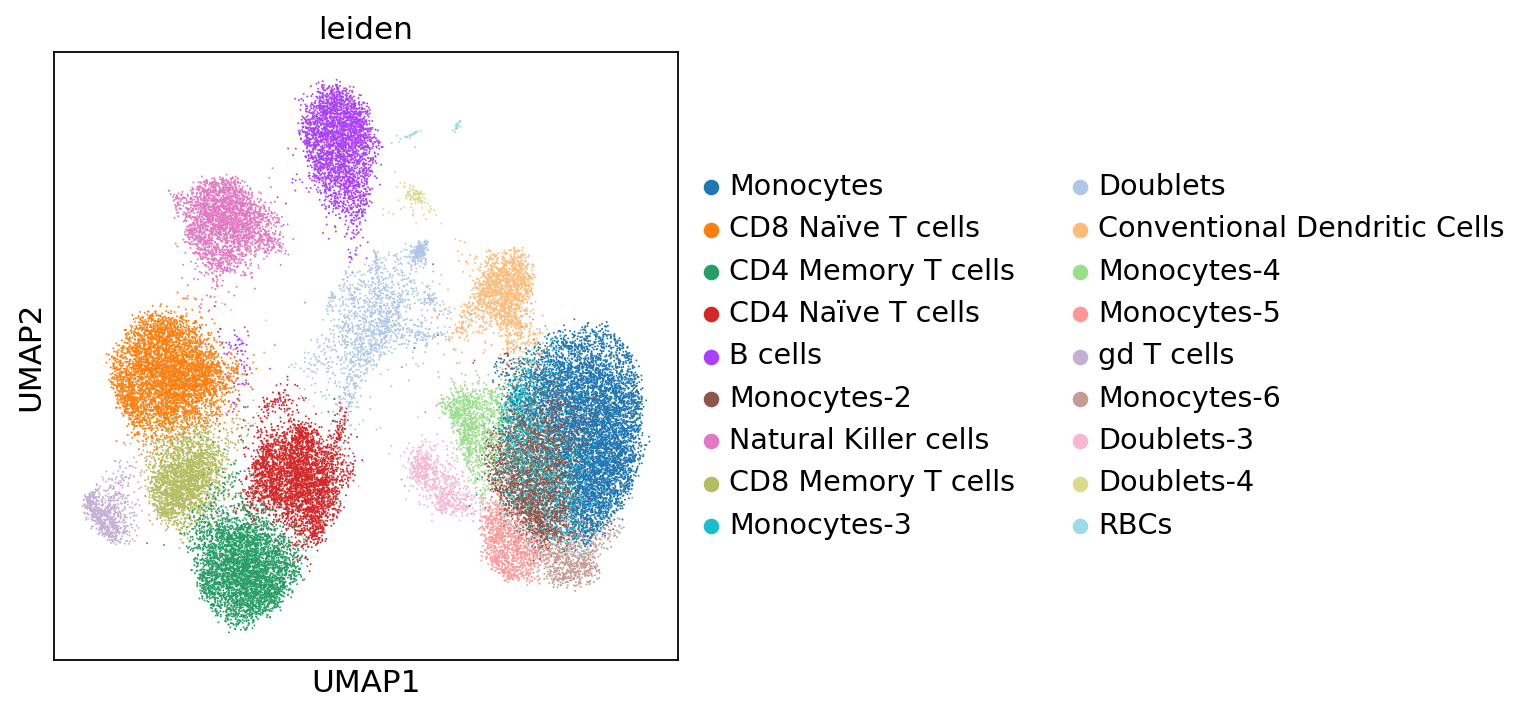

In [160]:
sc.pl.umap(adata_200k, color = 'leiden',save = '200223_200k_leiden.png')

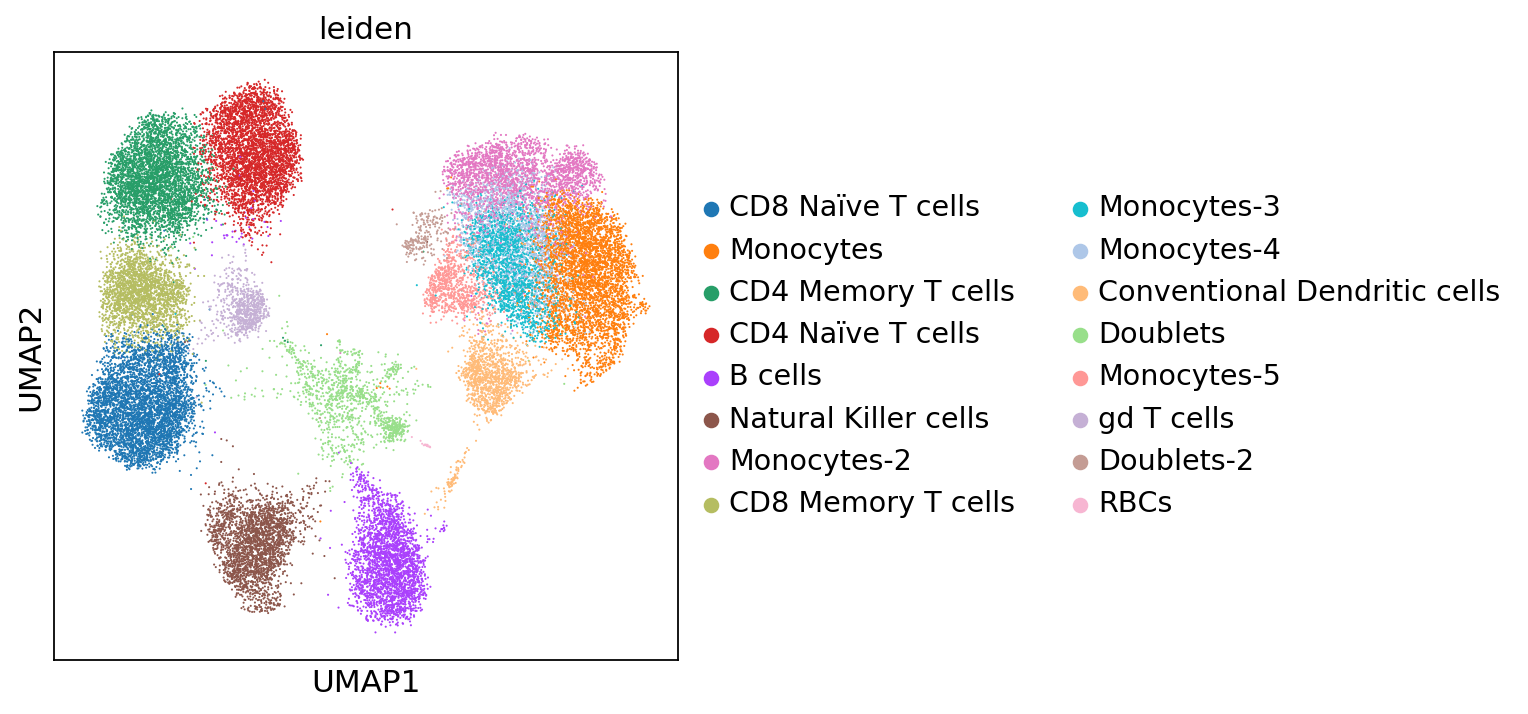

In [161]:
sc.pl.umap(adata_100k, color = 'leiden',save = '200223_100k_leiden.png')

In [162]:
#combine clusters
adata_100k.obs['leiden']=adata_100k.obs['leiden'].where(adata_100k.obs['leiden']!='Monocytes-2','Monocytes')
adata_100k.obs['leiden']=adata_100k.obs['leiden'].where(adata_100k.obs['leiden']!='Monocytes-3','Monocytes')
adata_100k.obs['leiden']=adata_100k.obs['leiden'].where(adata_100k.obs['leiden']!='Monocytes-4','Monocytes')
adata_100k.obs['leiden']=adata_100k.obs['leiden'].where(adata_100k.obs['leiden']!='Monocytes-5','Monocytes')
adata_100k.obs['leiden']=adata_100k.obs['leiden'].where(adata_100k.obs['leiden']!='Doublets-2','Doublets')



In [163]:
#combine clusters
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Monocytes-2','Monocytes')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Monocytes-3','Monocytes')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Monocytes-4','Monocytes')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Monocytes-5','Monocytes')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Monocytes-6','Monocytes')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Doublets-2','Doublets')
adata_200k.obs['leiden']=adata_200k.obs['leiden'].where(adata_200k.obs['leiden']!='Doublets-3','Doublets')



In [164]:
#remove doublets
adata_100k_nd = adata_100k[~adata_100k.obs['leiden'].isin(['Doublets']),:]

adata_200k_nd = adata_200k[~adata_200k.obs['leiden'].isin(['Doublets']),:]

In [165]:
donor0_100k_nd = adata_100k_nd[adata_100k_nd.obs['Demuxlet']== 'donor0']
donor1_100k_nd = adata_100k_nd[adata_100k_nd.obs['Demuxlet']== 'donor1']

donor0_100k_sng =donor0_100k_nd[donor0_100k_nd.obs['Type']== 'Singlet']
donor1_100k_sng =donor1_100k_nd[donor1_100k_nd.obs['Type']== 'Singlet']

donor0_100k_mpl =donor0_100k_nd[donor0_100k_nd.obs['Type']== 'Doublet']
donor1_100k_mpl =donor1_100k_nd[donor1_100k_nd.obs['Type']== 'Doublet']

In [171]:
donor0_100k_sng.obs['leiden']

X54-0                Monocytes
X108-0               Monocytes
X131-0      CD4 Memory T cells
X132-0               Monocytes
X149-0                 B cells
                   ...        
X34133-9             Monocytes
X34146-9     CD4 Naïve T cells
X34161-9    CD4 Memory T cells
X34252-9             Monocytes
X34286-9             Monocytes
Name: leiden, Length: 8956, dtype: category
Categories (9, object): [CD8 Naïve T cells, Monocytes, CD4 Memory T cells, CD4 Naïve T cells, ..., Natural Killer cells, CD8 Memory T cells, Conventional Dendritic cells, gd T cells]

In [189]:
donor0_200k_nd = adata_200k_nd[adata_200k_nd.obs['Demuxlet']== 'donor0']
donor1_200k_nd = adata_200k_nd[adata_200k_nd.obs['Demuxlet']== 'donor1']

donor0_200k_sng =donor0_200k_nd[donor0_200k_nd.obs['Type']== 'Singlet']
donor1_200k_sng =donor1_200k_nd[donor1_200k_nd.obs['Type']== 'Singlet']

donor0_200k_mpl =donor0_200k_nd[donor0_200k_nd.obs['Type']== 'Doublet']
donor1_200k_mpl =donor1_200k_nd[donor1_200k_nd.obs['Type']== 'Doublet']

In [167]:
#100k proportions

In [186]:
#donor0 100k_nd all
m = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='Monocytes')].shape[0]/(donor0_100k_nd.obs.shape[0])
cd8n = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_100k_nd.obs.shape[0]
cd4n = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_100k_nd.obs.shape[0]
cd4m = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_100k_nd.obs.shape[0]
b = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='B cells')].shape[0]/donor0_100k_nd.obs.shape[0]
cd8m = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_100k_nd.obs.shape[0]
nk = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_100k_nd.obs.shape[0]
cdc = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_100k_nd.obs.shape[0]
gdt = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='gd T cells')].shape[0]/donor0_100k_nd.obs.shape[0]
rbc = donor0_100k_nd[(donor0_100k_nd.obs['leiden']=='RBCs')].shape[0]/donor0_100k_nd.obs.shape[0]

donor0_100k_nd_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_100k_nd_proportions)



1.0

In [187]:
#donor1 100k all
m = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='Monocytes')].shape[0]/(donor1_100k_nd.obs.shape[0])
cd8n = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_100k_nd.obs.shape[0]
cd4n = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_100k_nd.obs.shape[0]
cd4m = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_100k_nd.obs.shape[0]
b = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='B cells')].shape[0]/donor1_100k_nd.obs.shape[0]
cd8m = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_100k_nd.obs.shape[0]
nk = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_100k_nd.obs.shape[0]
cdc = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_100k_nd.obs.shape[0]
gdt = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='gd T cells')].shape[0]/donor1_100k_nd.obs.shape[0]
rbc = donor1_100k_nd[(donor1_100k_nd.obs['leiden']=='RBCs')].shape[0]/donor1_100k_nd.obs.shape[0]

donor1_100k_nd_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_100k_nd_proportions)





1.0

In [194]:
#donor0 100k_sng
m = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='Monocytes')].shape[0]/(donor0_100k_sng.obs.shape[0])
cd8n = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_100k_sng.obs.shape[0]
cd4n = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_100k_sng.obs.shape[0]
cd4m = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_100k_sng.obs.shape[0]
b = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='B cells')].shape[0]/donor0_100k_sng.obs.shape[0]
cd8m = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_100k_sng.obs.shape[0]
nk = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_100k_sng.obs.shape[0]
cdc = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_100k_sng.obs.shape[0]
gdt = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='gd T cells')].shape[0]/donor0_100k_sng.obs.shape[0]
rbc = donor0_100k_sng[(donor0_100k_sng.obs['leiden']=='RBCs')].shape[0]/donor0_100k_sng.obs.shape[0]

donor0_100k_sng_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_100k_sng_proportions)



1.0

In [195]:
#donor1 100k_sng
m = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='Monocytes')].shape[0]/(donor1_100k_sng.obs.shape[0])
cd8n = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_100k_sng.obs.shape[0]
cd4n = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_100k_sng.obs.shape[0]
cd4m = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_100k_sng.obs.shape[0]
b = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='B cells')].shape[0]/donor1_100k_sng.obs.shape[0]
cd8m = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_100k_sng.obs.shape[0]
nk = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_100k_sng.obs.shape[0]
cdc = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_100k_sng.obs.shape[0]
gdt = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='gd T cells')].shape[0]/donor1_100k_sng.obs.shape[0]
rbc = donor1_100k_sng[(donor1_100k_sng.obs['leiden']=='RBCs')].shape[0]/donor1_100k_sng.obs.shape[0]

donor1_100k_sng_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_100k_sng_proportions)



1.0

In [196]:
#donor0 100k_mpl
m = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='Monocytes')].shape[0]/(donor0_100k_mpl.obs.shape[0])
cd8n = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
cd4n = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
cd4m = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
b = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='B cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
cd8m = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_100k_mpl.obs.shape[0]
nk = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
cdc = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
gdt = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='gd T cells')].shape[0]/donor0_100k_mpl.obs.shape[0]
rbc = donor0_100k_mpl[(donor0_100k_mpl.obs['leiden']=='RBCs')].shape[0]/donor0_100k_mpl.obs.shape[0]

donor0_100k_mpl_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_100k_mpl_proportions)



1.0

In [197]:
#donor1 100k_mpl
m = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='Monocytes')].shape[0]/(donor1_100k_mpl.obs.shape[0])
cd8n = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
cd4n = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
cd4m = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
b = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='B cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
cd8m = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_100k_mpl.obs.shape[0]
nk = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
cdc = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
gdt = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='gd T cells')].shape[0]/donor1_100k_mpl.obs.shape[0]
rbc = donor1_100k_mpl[(donor1_100k_mpl.obs['leiden']=='RBCs')].shape[0]/donor1_100k_mpl.obs.shape[0]

donor1_100k_mpl_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_100k_mpl_proportions)



1.0

In [ ]:
#200k proportions

In [205]:
#donor0 200k_nd all
m = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='Monocytes')].shape[0]/(donor0_200k_nd.obs.shape[0])
cd8n = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_200k_nd.obs.shape[0]
cd4n = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_200k_nd.obs.shape[0]
cd4m = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_200k_nd.obs.shape[0]
b = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='B cells')].shape[0]/donor0_200k_nd.obs.shape[0]
cd8m = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_200k_nd.obs.shape[0]
nk = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_200k_nd.obs.shape[0]
cdc = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_200k_nd.obs.shape[0]
gdt = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='gd T cells')].shape[0]/donor0_200k_nd.obs.shape[0]
rbc = donor0_200k_nd[(donor0_200k_nd.obs['leiden']=='RBCs')].shape[0]/donor0_200k_nd.obs.shape[0]

donor0_200k_nd_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_200k_nd_proportions)



1.0

In [207]:
#donor1 200k all
m = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='Monocytes')].shape[0]/(donor1_200k_nd.obs.shape[0])
cd8n = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_200k_nd.obs.shape[0]
cd4n = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_200k_nd.obs.shape[0]
cd4m = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_200k_nd.obs.shape[0]
b = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='B cells')].shape[0]/donor1_200k_nd.obs.shape[0]
cd8m = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_200k_nd.obs.shape[0]
nk = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_200k_nd.obs.shape[0]
cdc = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_200k_nd.obs.shape[0]
gdt = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='gd T cells')].shape[0]/donor1_200k_nd.obs.shape[0]
rbc = donor1_200k_nd[(donor1_200k_nd.obs['leiden']=='RBCs')].shape[0]/donor1_200k_nd.obs.shape[0]

donor1_200k_nd_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_200k_nd_proportions)





1.0

In [208]:
#donor0 200k_sng
m = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='Monocytes')].shape[0]/(donor0_200k_sng.obs.shape[0])
cd8n = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_200k_sng.obs.shape[0]
cd4n = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_200k_sng.obs.shape[0]
cd4m = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_200k_sng.obs.shape[0]
b = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='B cells')].shape[0]/donor0_200k_sng.obs.shape[0]
cd8m = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_200k_sng.obs.shape[0]
nk = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_200k_sng.obs.shape[0]
cdc = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_200k_sng.obs.shape[0]
gdt = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='gd T cells')].shape[0]/donor0_200k_sng.obs.shape[0]
rbc = donor0_200k_sng[(donor0_200k_sng.obs['leiden']=='RBCs')].shape[0]/donor0_200k_sng.obs.shape[0]

donor0_200k_sng_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_200k_sng_proportions)



1.0

In [209]:
#donor1 200k_sng
m = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='Monocytes')].shape[0]/(donor1_200k_sng.obs.shape[0])
cd8n = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_200k_sng.obs.shape[0]
cd4n = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_200k_sng.obs.shape[0]
cd4m = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_200k_sng.obs.shape[0]
b = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='B cells')].shape[0]/donor1_200k_sng.obs.shape[0]
cd8m = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_200k_sng.obs.shape[0]
nk = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_200k_sng.obs.shape[0]
cdc = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_200k_sng.obs.shape[0]
gdt = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='gd T cells')].shape[0]/donor1_200k_sng.obs.shape[0]
rbc = donor1_200k_sng[(donor1_200k_sng.obs['leiden']=='RBCs')].shape[0]/donor1_200k_sng.obs.shape[0]

donor1_200k_sng_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_200k_sng_proportions)



1.0

In [210]:
#donor0 200k_mpl
m = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='Monocytes')].shape[0]/(donor0_200k_mpl.obs.shape[0])
cd8n = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
cd4n = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
cd4m = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
b = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='B cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
cd8m = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor0_200k_mpl.obs.shape[0]
nk = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='Natural Killer cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
cdc = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
gdt = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='gd T cells')].shape[0]/donor0_200k_mpl.obs.shape[0]
rbc = donor0_200k_mpl[(donor0_200k_mpl.obs['leiden']=='RBCs')].shape[0]/donor0_200k_mpl.obs.shape[0]

donor0_200k_mpl_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor0_200k_mpl_proportions)



1.0

In [211]:
#donor1 200k_mpl
m = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='Monocytes')].shape[0]/(donor1_200k_mpl.obs.shape[0])
cd8n = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='CD8 Naïve T cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
cd4n = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='CD4 Naïve T cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
cd4m = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='CD4 Memory T cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
b = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='B cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
cd8m = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='CD8 Memory T cells') ].shape[0]/donor1_200k_mpl.obs.shape[0]
nk = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='Natural Killer cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
cdc = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='Conventional Dendritic cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
gdt = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='gd T cells')].shape[0]/donor1_200k_mpl.obs.shape[0]
rbc = donor1_200k_mpl[(donor1_200k_mpl.obs['leiden']=='RBCs')].shape[0]/donor1_200k_mpl.obs.shape[0]

donor1_200k_mpl_proportions = [m,cd8n,cd4n,cd4m,b,cd8m,nk,cdc,gdt,rbc]

np.sum(donor1_200k_mpl_proportions)



1.0

In [226]:
donor0_100k_nd_proportions

[0.31390007372540124,
 0.2004763795156808,
 0.10315884988374072,
 0.09244031078092213,
 0.05240174672489083,
 0.06663642034821074,
 0.09312085294618046,
 0.04321442749390347,
 0.03402710826291612,
 0.0006238303181534623]

In [227]:
donor1_100k_nd_proportions

[0.45324373223055053,
 0.05789609718273456,
 0.09351253553889895,
 0.12504523132592402,
 0.10566037735849057,
 0.06084259498578444,
 0.048332902558800725,
 0.04512794003618506,
 0.008581028689583872,
 0.001757560093047299]

In [228]:
donor0_100k_sng_proportions

[0.39236873206145534,
 0.20192470032078338,
 0.0715853452642242,
 0.07310484551747426,
 0.03190950531825089,
 0.05216950869491811,
 0.10957285159547527,
 0.043559007259834547,
 0.023636670606111767,
 0.00016883336147222692]

In [229]:
donor1_100k_sng_proportions

[0.5533354310887351,
 0.048458149779735685,
 0.0684392699811202,
 0.10682819383259912,
 0.07221522970421648,
 0.04499685336689742,
 0.04908747640025173,
 0.05066079295154185,
 0.004562617998741347,
 0.0014159848961611077]

In [230]:
donor0_100k_mpl_proportions

[0.27421007685738685,
 0.19974380871050385,
 0.11912894961571306,
 0.10222032450896669,
 0.0627668659265585,
 0.07395388556789069,
 0.08479931682322801,
 0.0430401366353544,
 0.03928266438941076,
 0.0008539709649871904]

In [231]:
donor1_100k_mpl_proportions

[0.40426514743244285,
 0.06251443529140041,
 0.10578181538224651,
 0.13395950419585803,
 0.12202632997151436,
 0.06859650473477558,
 0.04796366155978135,
 0.04242050966202171,
 0.010547386249903765,
 0.0019247055200554315]

In [238]:
donor0_200k_nd_proportions

[0.31390007372540124,
 0.2004763795156808,
 0.10315884988374072,
 0.09244031078092213,
 0.05240174672489083,
 0.06663642034821074,
 0.09312085294618046,
 0.04321442749390347,
 0.03402710826291612,
 0.0006238303181534623]

In [239]:
donor1_200k_nd_proportions

[0.45324373223055053,
 0.05789609718273456,
 0.09351253553889895,
 0.12504523132592402,
 0.10566037735849057,
 0.06084259498578444,
 0.048332902558800725,
 0.04512794003618506,
 0.008581028689583872,
 0.001757560093047299]

In [240]:
donor0_200k_sng_proportions

[0.39236873206145534,
 0.20192470032078338,
 0.0715853452642242,
 0.07310484551747426,
 0.03190950531825089,
 0.05216950869491811,
 0.10957285159547527,
 0.043559007259834547,
 0.023636670606111767,
 0.00016883336147222692]

In [241]:
donor1_200k_sng_proportions

[0.5533354310887351,
 0.048458149779735685,
 0.0684392699811202,
 0.10682819383259912,
 0.07221522970421648,
 0.04499685336689742,
 0.04908747640025173,
 0.05066079295154185,
 0.004562617998741347,
 0.0014159848961611077]

In [242]:
donor0_200k_mpl_proportions

[0.27421007685738685,
 0.19974380871050385,
 0.11912894961571306,
 0.10222032450896669,
 0.0627668659265585,
 0.07395388556789069,
 0.08479931682322801,
 0.0430401366353544,
 0.03928266438941076,
 0.0008539709649871904]

In [243]:
donor1_200k_mpl_proportions

[0.40426514743244285,
 0.06251443529140041,
 0.10578181538224651,
 0.13395950419585803,
 0.12202632997151436,
 0.06859650473477558,
 0.04796366155978135,
 0.04242050966202171,
 0.010547386249903765,
 0.0019247055200554315]

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


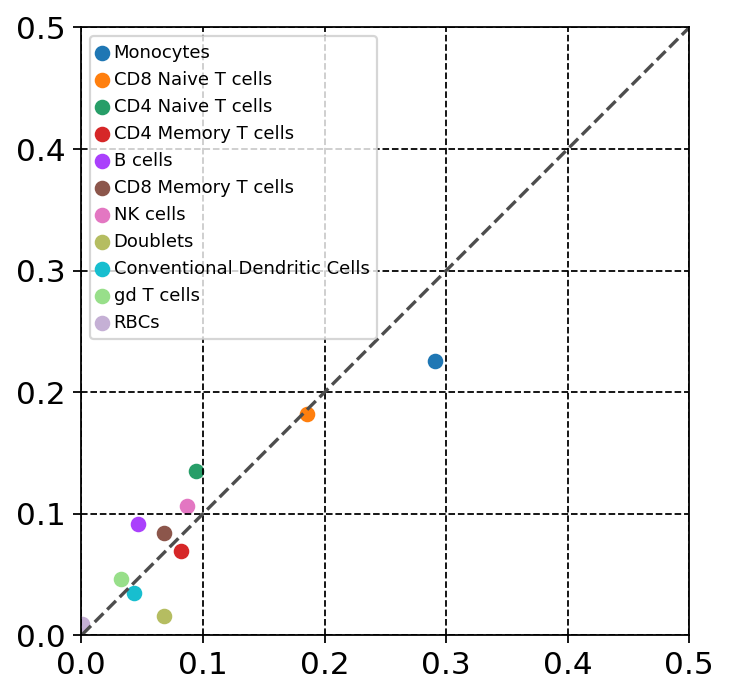

In [1241]:
#200k donor0 all, TMA-001
fig, ax = plt.subplots()

x=d0_200k_all_proportions
y=cytof_umap_proportions_001
xlabel='d0_200k_all'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


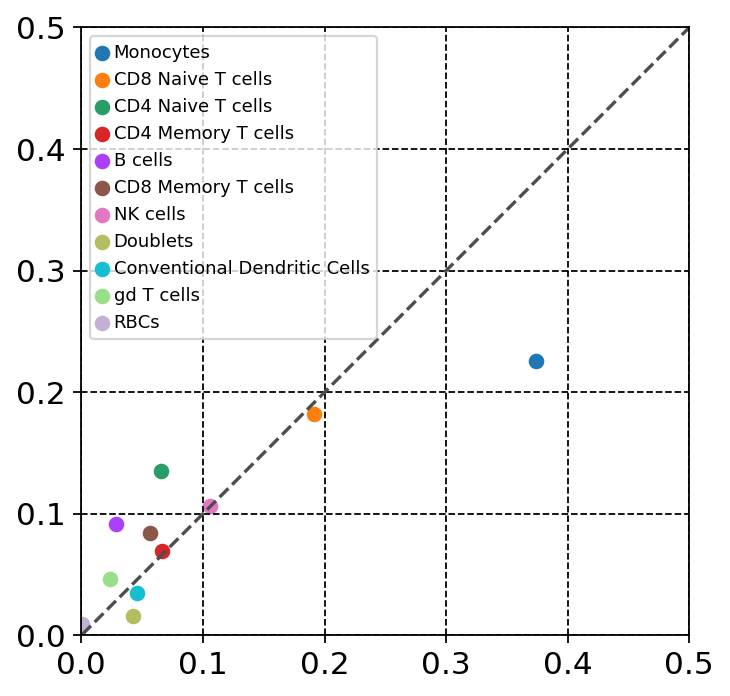

In [1242]:
#200k donor0 sng, TMA-001
fig, ax = plt.subplots()

x=d0_200k_sng_proportions
y=cytof_umap_proportions_001
xlabel='d0_200k_singlets'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


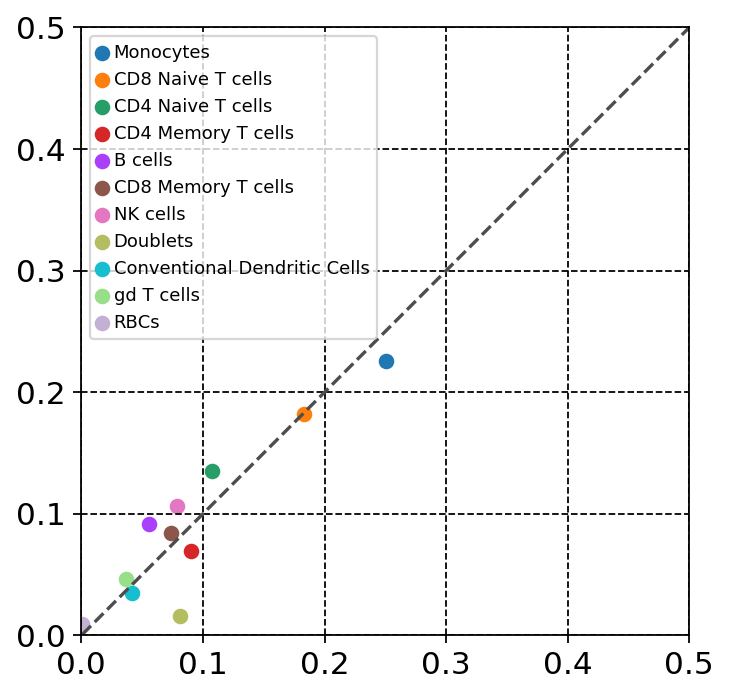

In [1243]:
#200k donor0 mpl, TMA-001
fig, ax = plt.subplots()

x=d0_200k_mpl_proportions
y=cytof_umap_proportions_001
xlabel='d0_200k_multiplets'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


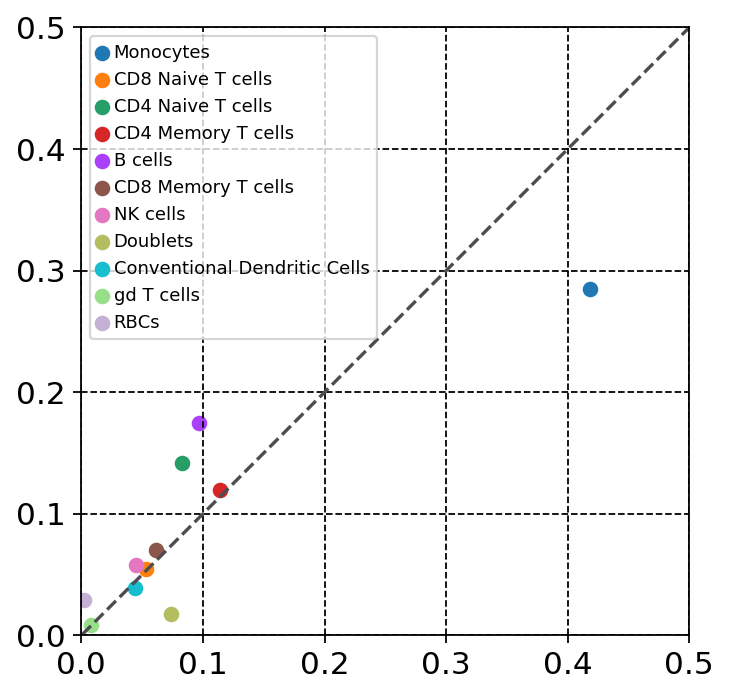

In [1247]:
#200k donor1 all, TMA-003
fig, ax = plt.subplots()

x=d1_200k_all_proportions
y=cytof_umap_proportions_003
xlabel='d1_200k_all'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


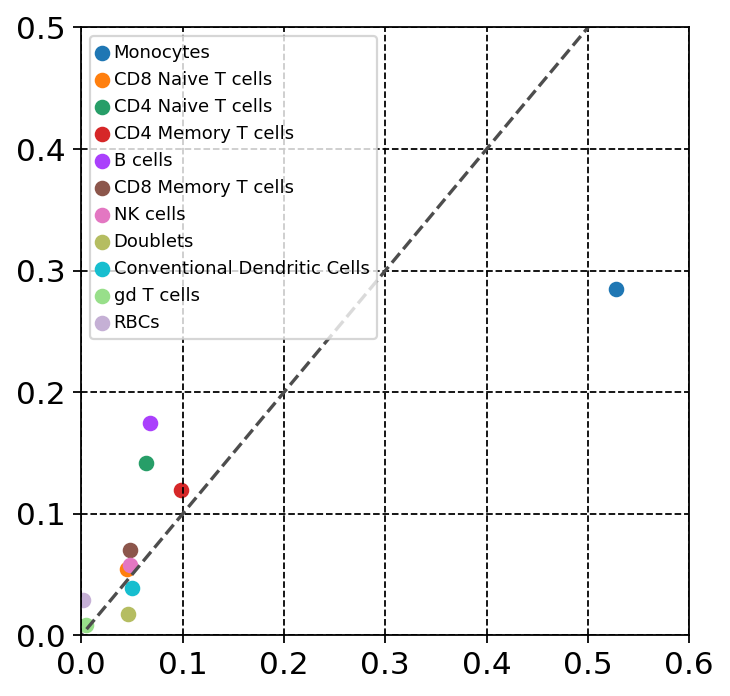

In [1253]:
#200k donor1 sng, TMA-003
fig, ax = plt.subplots()

x=d1_200k_sng_proportions
y=cytof_umap_proportions_003
xlabel='d1_200k_singlets'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.6))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


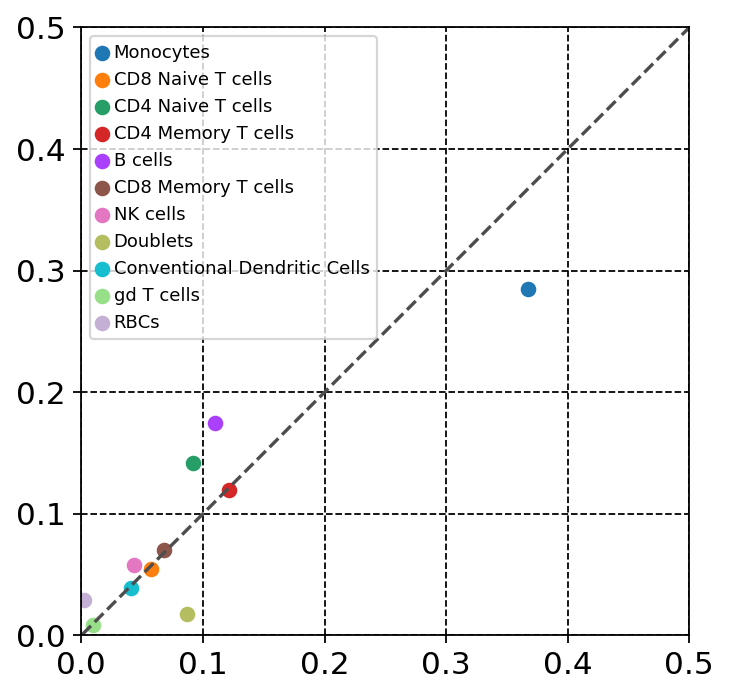

In [1249]:
#200k donor1 mpl, TMA-003
fig, ax = plt.subplots()

x=d1_200k_mpl_proportions
y=cytof_umap_proportions_003
xlabel='d1_200k_multiplets'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


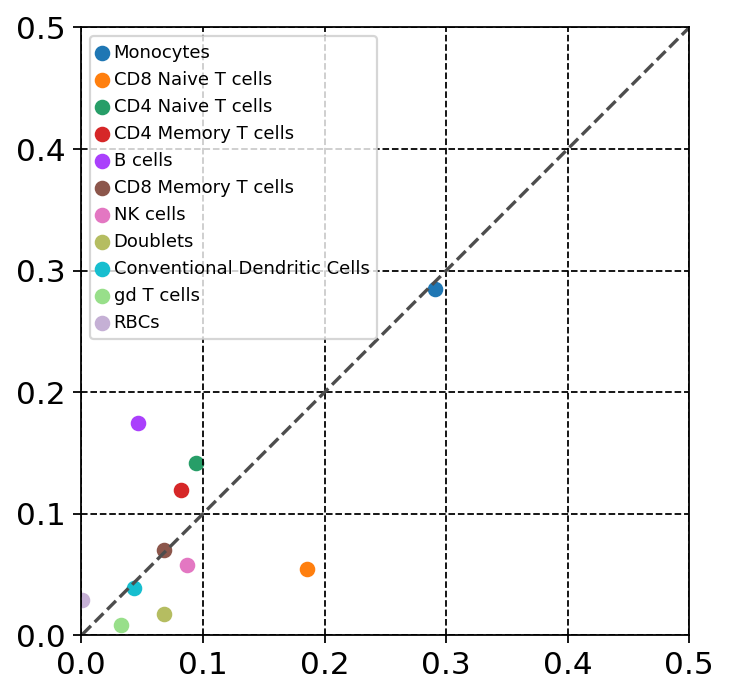

In [1305]:
#200k donor0 all, TMA-003
fig, ax = plt.subplots()

x=d0_200k_all_proportions
y=cytof_umap_proportions_003
xlabel='d0_200k_all'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


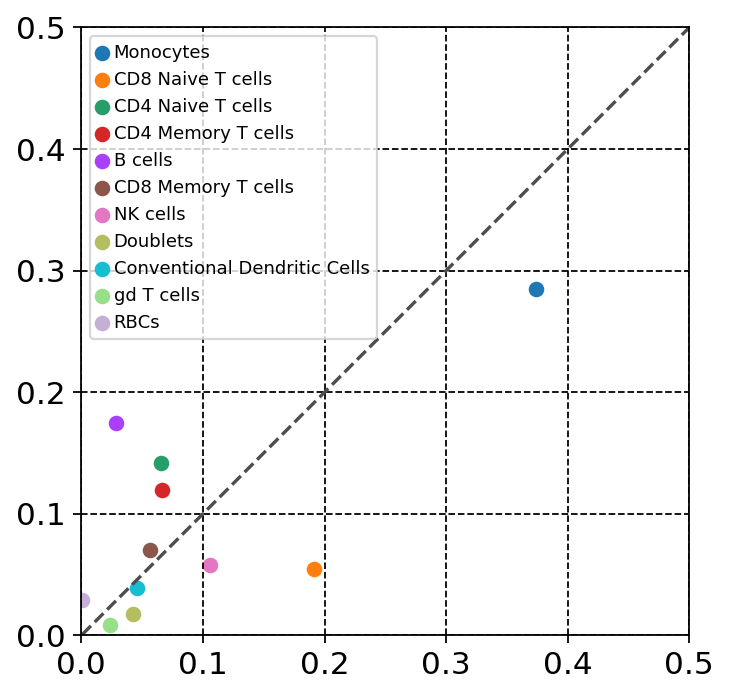

In [1306]:
#200k donor0 sng, TMA-003
fig, ax = plt.subplots()

x=d0_200k_sng_proportions
y=cytof_umap_proportions_003
xlabel='d0_200k_singlets'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


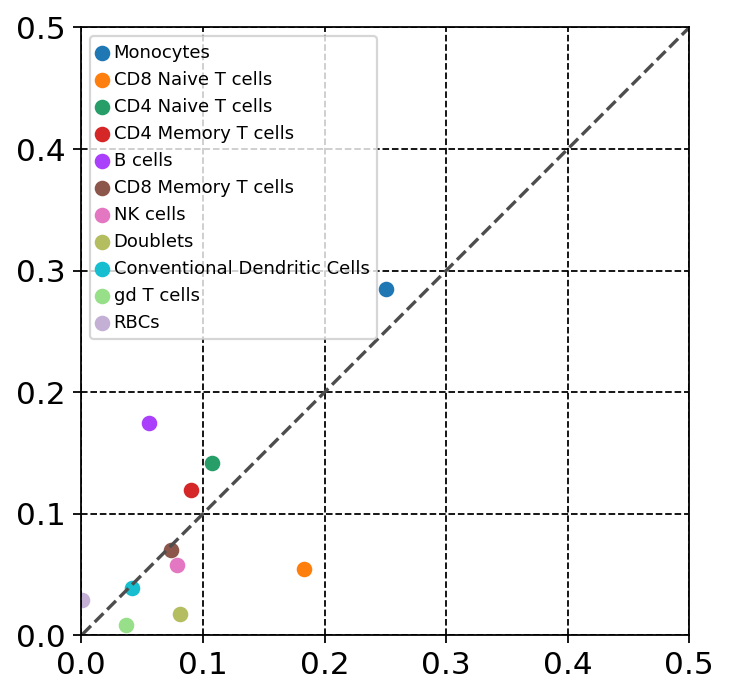

In [1307]:
#200k donor0 mpl, TMA-003
fig, ax = plt.subplots()

x=d0_200k_mpl_proportions
y=cytof_umap_proportions_003
xlabel='d0_200k_multiplets'
ylabel='cytof_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


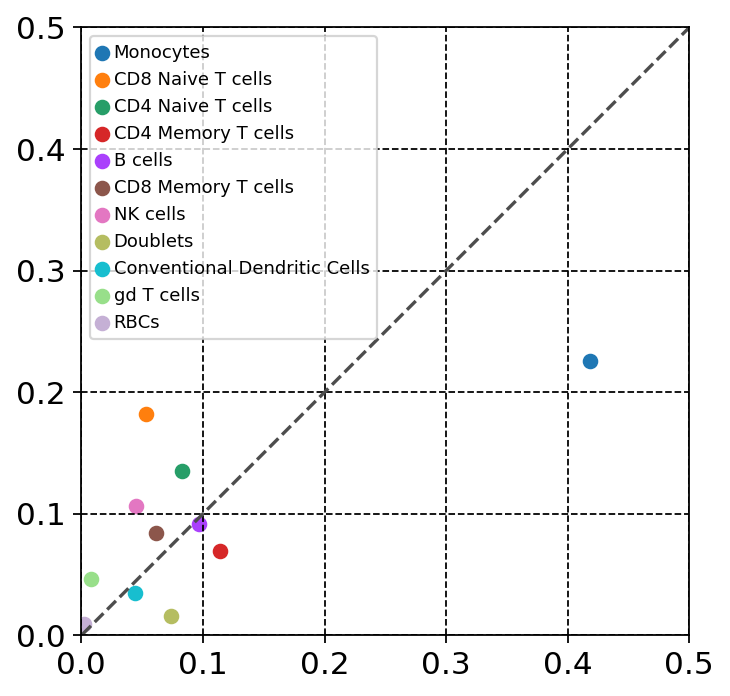

In [1311]:
#200k donor1 all, TMA-001
fig, ax = plt.subplots()

x=d1_200k_all_proportions
y=cytof_umap_proportions_001
xlabel='d1_200k_all'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


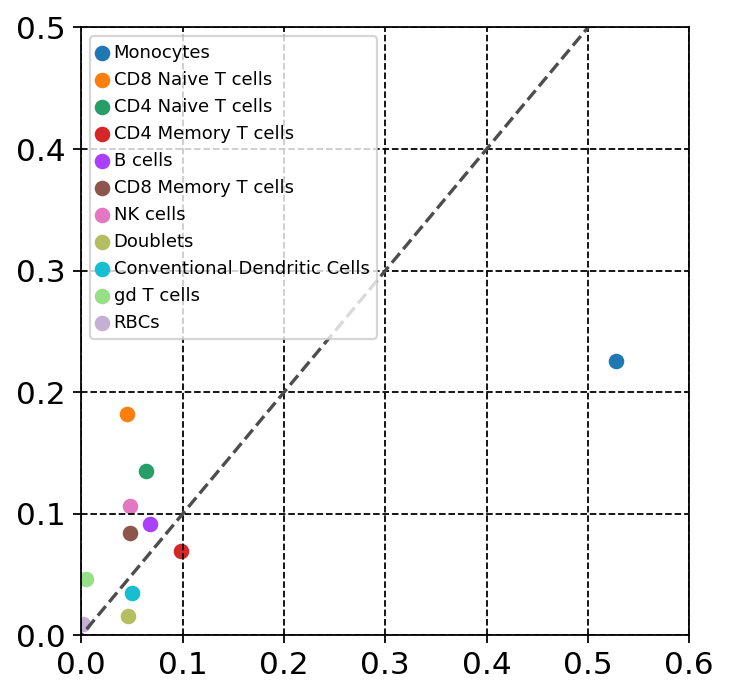

In [1312]:
#200k donor1 sng, TMA-001
fig, ax = plt.subplots()

x=d1_200k_sng_proportions
y=cytof_umap_proportions_001
xlabel='d1_200k_singlets'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.6))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200219
/wynton/group/ye/david/Cyto-seq/200204


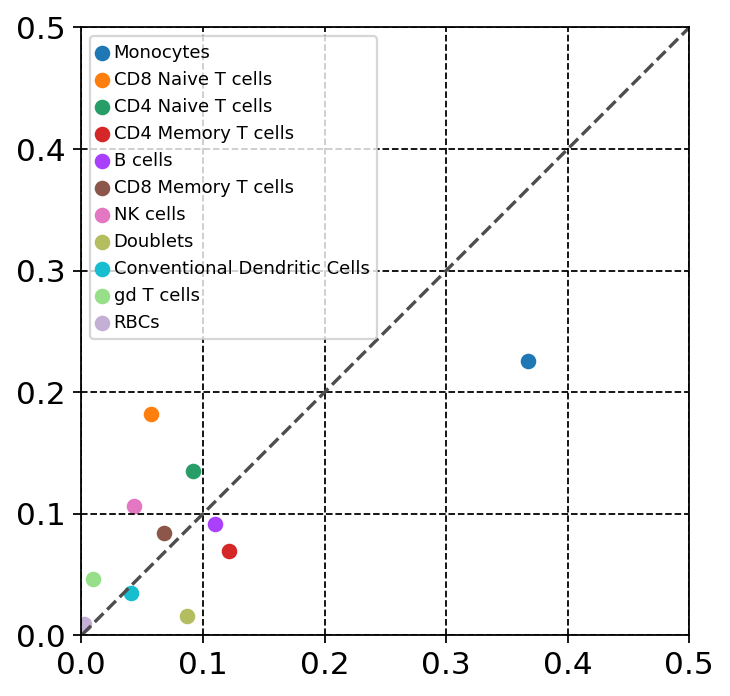

In [1313]:
#200k donor1 mpl, TMA-001
fig, ax = plt.subplots()

x=d1_200k_mpl_proportions
y=cytof_umap_proportions_001
xlabel='d1_200k_multiplets'
ylabel='cytof_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', color=colors[2])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', color=colors[3])
B  = plt.scatter(x[4], y[4], marker='o', color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', color=colors[6])
doublets = plt.scatter(x[7], y[7], marker='o', color=colors[7])
cDC = plt.scatter(x[8], y[8], marker='o', color=colors[8])
gd  = plt.scatter(x[9], y[9], marker='o', color=colors[11])
rbc  = plt.scatter(x[10], y[10], marker='o', color=colors[13])

plt.legend((CD14,CD8_naive,CD4_naive,CD4_mem,B,CD8_mem,NK,doublets,cDC,gd,rbc),
           ('Monocytes','CD8 Naive T cells','CD4 Naive T cells','CD4 Memory T cells','B cells','CD8 Memory T cells',
                     'NK cells','Doublets','Conventional Dendritic Cells',
                     'gd T cells','RBCs'),loc = 'upper left', fontsize = 'xx-small')

ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200219"
fig.savefig((xlabel+'_'+ylabel+'_correlation'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

In [1244]:
stats.pearsonr(d0_200k_all_proportions, cytof_umap_proportions_001)

(0.9083490618447366, 0.00010940630201415221)

In [1245]:
stats.pearsonr(d0_200k_sng_proportions, cytof_umap_proportions_001)

(0.8740039822159776, 0.000435284832086007)

In [1246]:
stats.pearsonr(d0_200k_mpl_proportions, cytof_umap_proportions_001)

(0.9133345017177846, 8.569211906659027e-05)

In [1250]:
stats.pearsonr(d1_200k_all_proportions, cytof_umap_proportions_003)

(0.8824146160437956, 0.00032302486679157335)

In [1251]:
stats.pearsonr(d1_200k_sng_proportions, cytof_umap_proportions_003)

(0.8441396423539611, 0.0010836319522668858)

In [1252]:
stats.pearsonr(d1_200k_mpl_proportions, cytof_umap_proportions_003)

(0.8990040441544345, 0.00016701941705506404)

In [1308]:
stats.pearsonr(d0_200k_all_proportions, cytof_umap_proportions_003)

(0.6898184891543225, 0.018828424421351297)

In [1309]:
stats.pearsonr(d0_200k_sng_proportions, cytof_umap_proportions_003)

(0.6892757417830592, 0.018960493470575927)

In [1310]:
stats.pearsonr(d0_200k_mpl_proportions, cytof_umap_proportions_003)

(0.6747653849749132, 0.022742073047860932)

In [1314]:
stats.pearsonr(d1_200k_all_proportions, cytof_umap_proportions_001)

(0.6983674981632857, 0.016833867971322004)

In [1315]:
stats.pearsonr(d1_200k_sng_proportions, cytof_umap_proportions_001)

(0.6941162173793062, 0.017805749346478668)

In [1316]:
stats.pearsonr(d1_200k_mpl_proportions, cytof_umap_proportions_001)

(0.6933507889304339, 0.017984906090452214)

In [1640]:
#Cytof with no doublets correlation_no_legend

In [1641]:
#100k

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


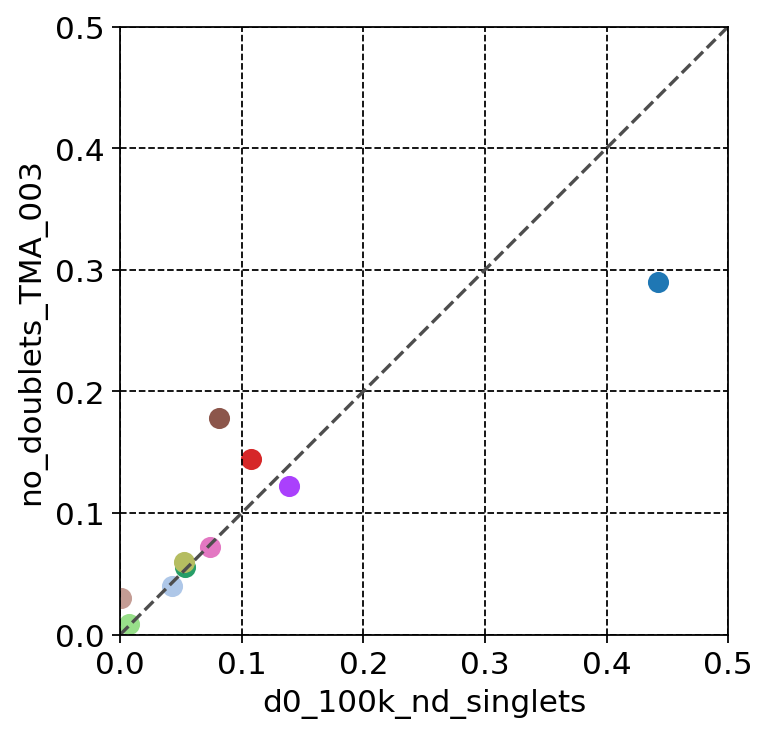

In [1642]:
# d0_100k_nd_sng_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_100k_nd_sng_proportions
y=no_doublets_TMA_003
xlabel='d0_100k_nd_singlets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


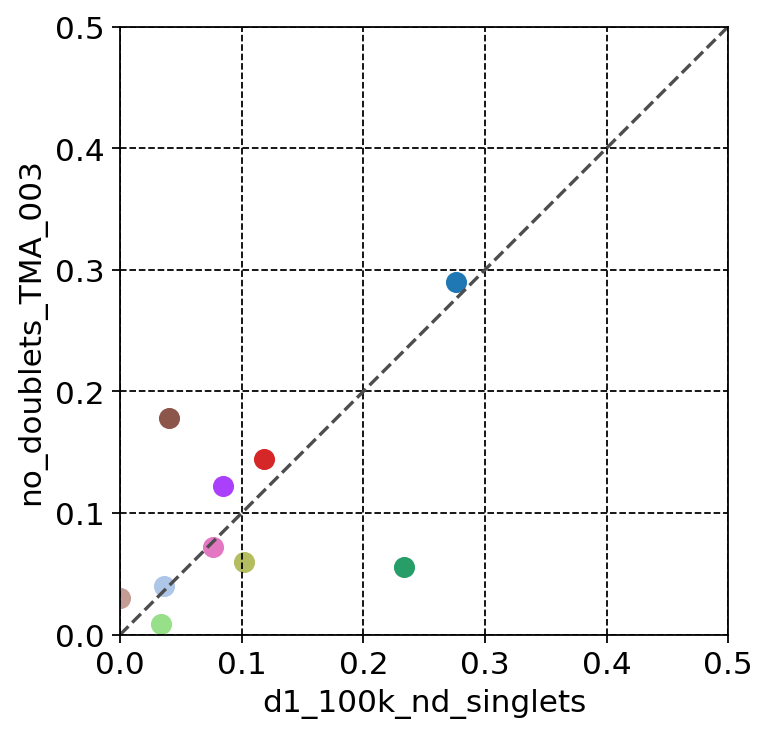

In [1643]:
# d1_100k_nd_sng_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_100k_nd_sng_proportions
y=no_doublets_TMA_003
xlabel='d1_100k_nd_singlets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


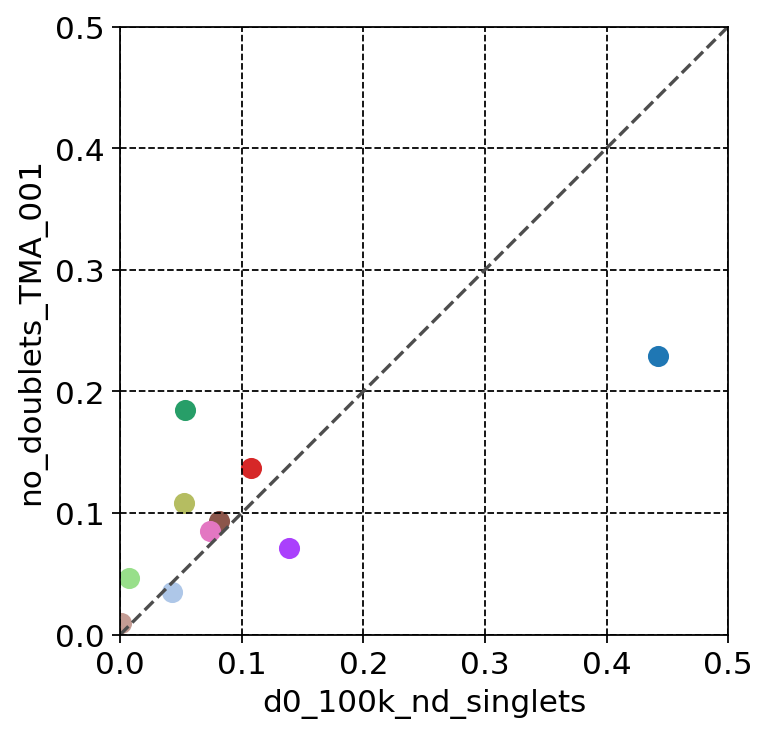

In [1644]:
# d0_100k_nd_sng_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_100k_nd_sng_proportions
y=no_doublets_TMA_001
xlabel='d0_100k_nd_singlets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


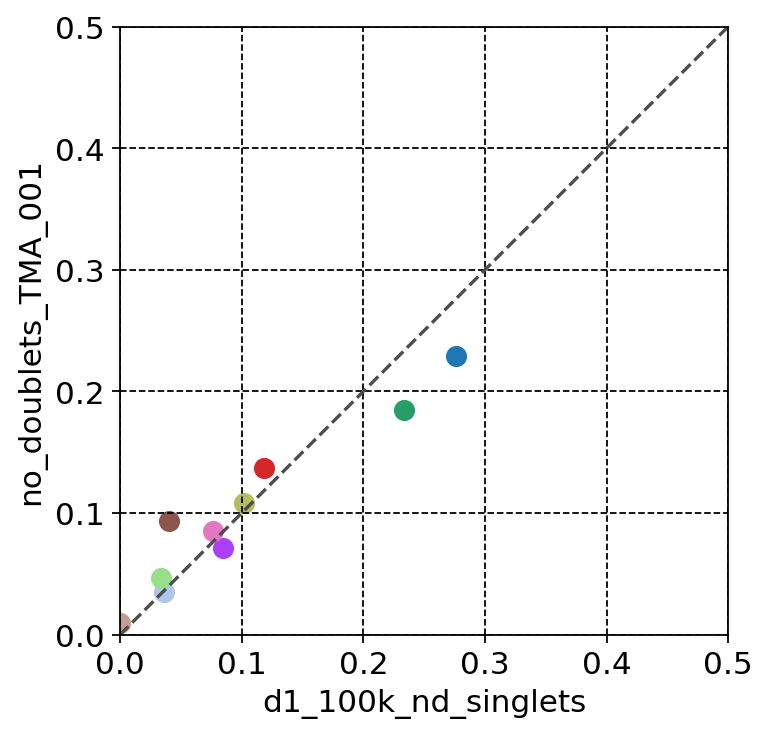

In [1645]:
# d1_100k_nd_sng_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_100k_nd_sng_proportions
y=no_doublets_TMA_001
xlabel='d1_100k_nd_singlets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


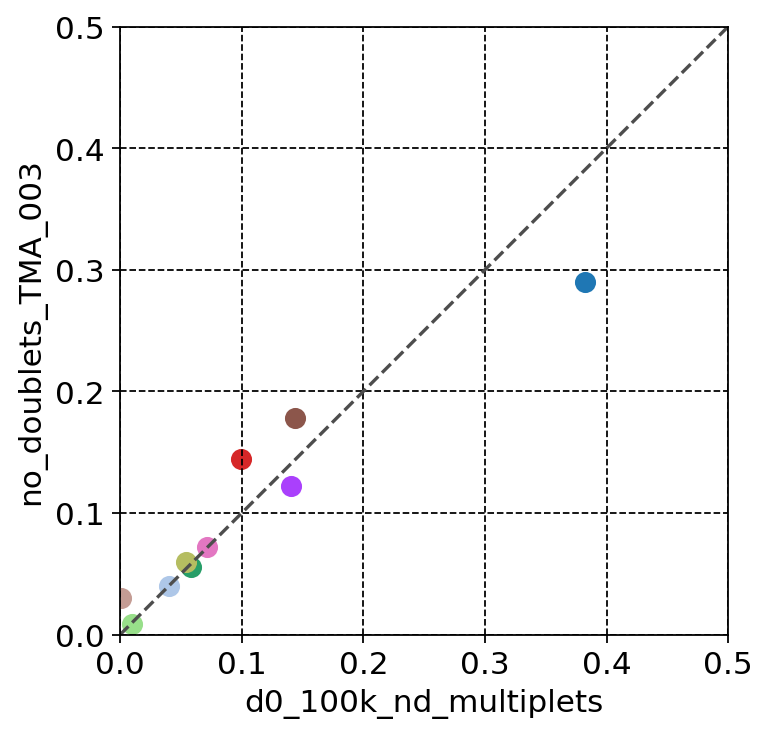

In [1646]:
# d0_100k_nd_mpl_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_100k_nd_mpl_proportions
y=no_doublets_TMA_003
xlabel='d0_100k_nd_multiplets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


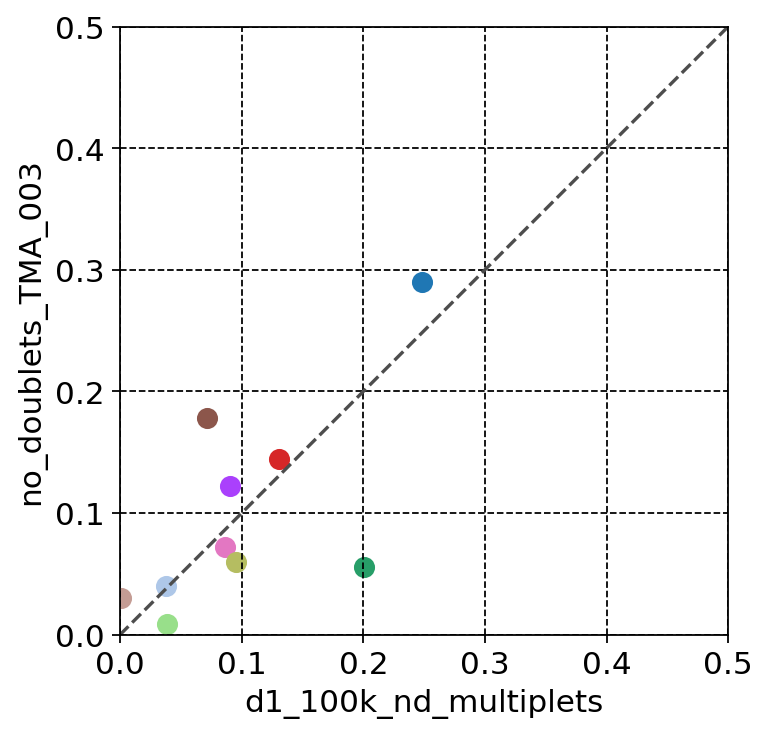

In [1647]:
# d1_100k_nd_mpl_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_100k_nd_mpl_proportions
y=no_doublets_TMA_003
xlabel='d1_100k_nd_multiplets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


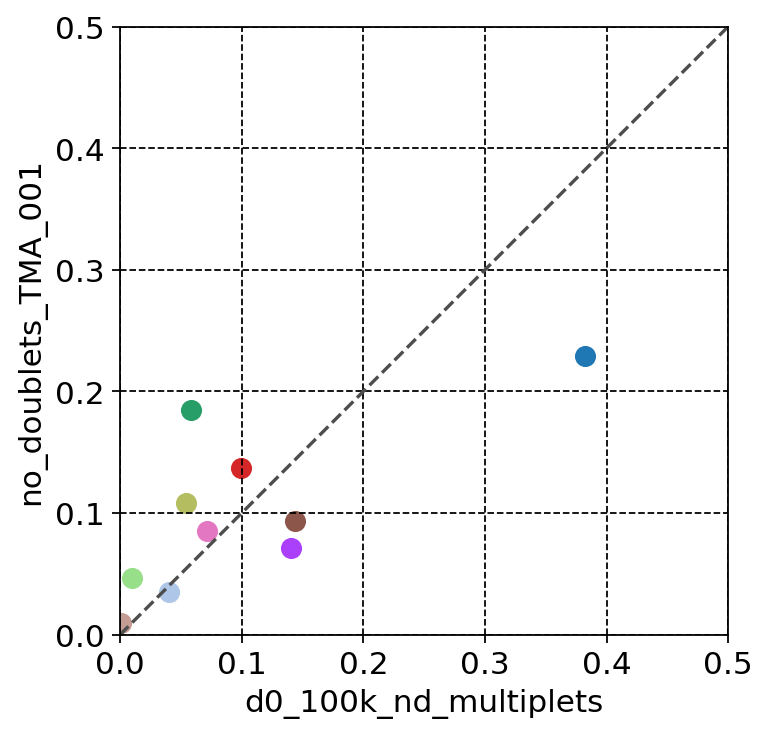

In [1648]:
# d0_100k_nd_mpl_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_100k_nd_mpl_proportions
y=no_doublets_TMA_001
xlabel='d0_100k_nd_multiplets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


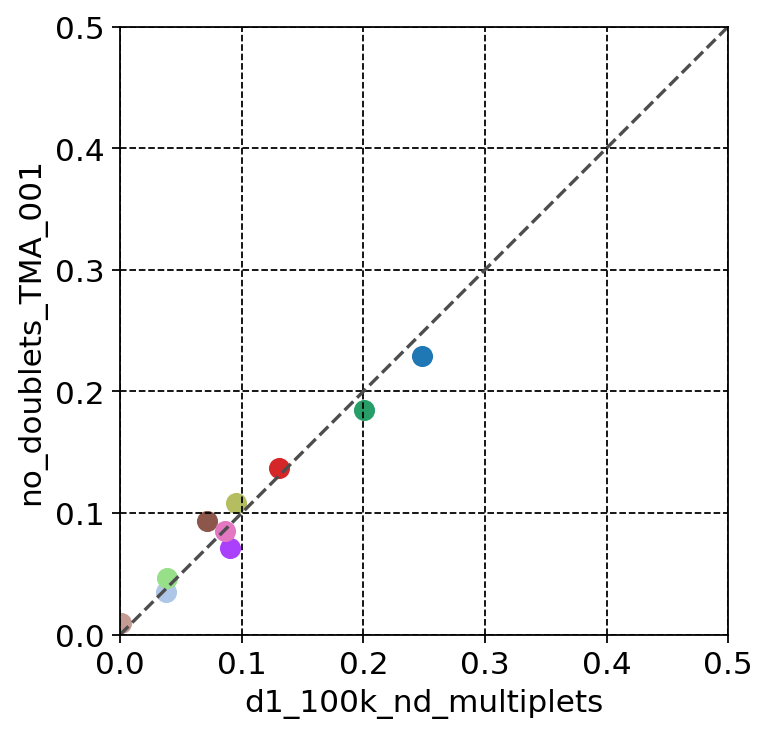

In [1649]:
# d1_100k_nd_mpl_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_100k_nd_mpl_proportions
y=no_doublets_TMA_001
xlabel='d1_100k_nd_multiplets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


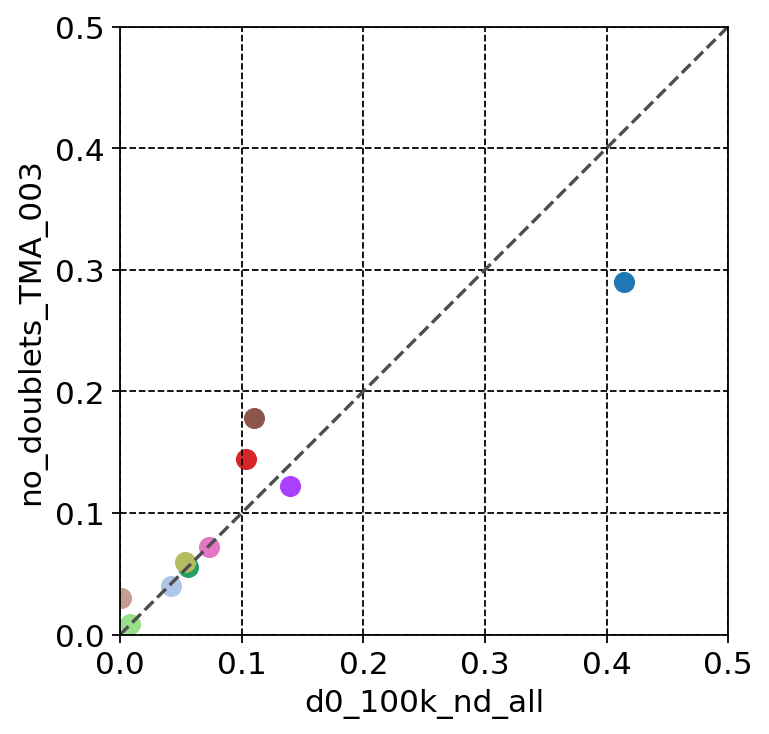

In [1650]:
# d0_100k_nd_all_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_100k_nd_all_proportions
y=no_doublets_TMA_003
xlabel='d0_100k_nd_all'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


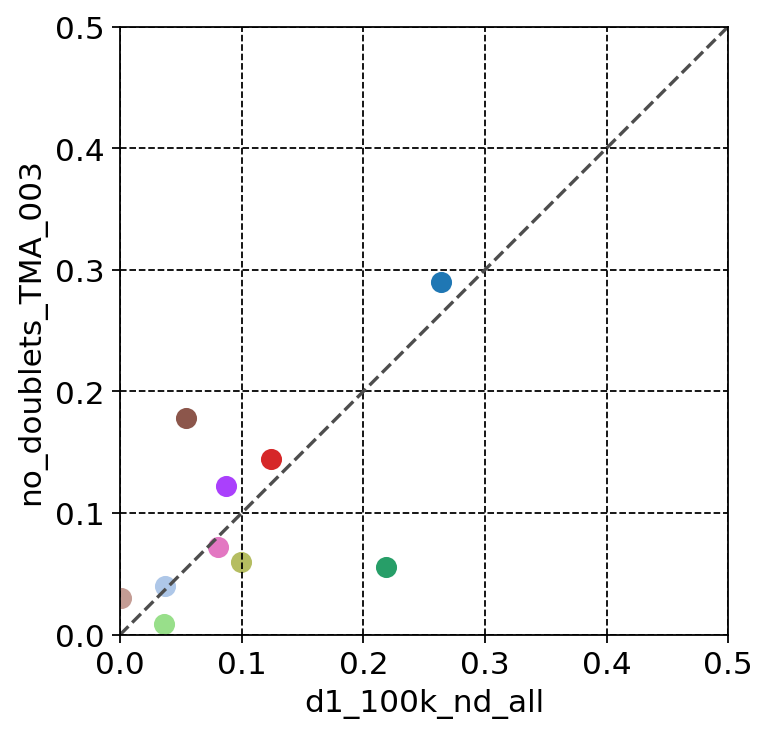

In [1651]:
# d1_100k_nd_all_proportions, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_100k_nd_all_proportions
y=no_doublets_TMA_003
xlabel='d1_100k_nd_all'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


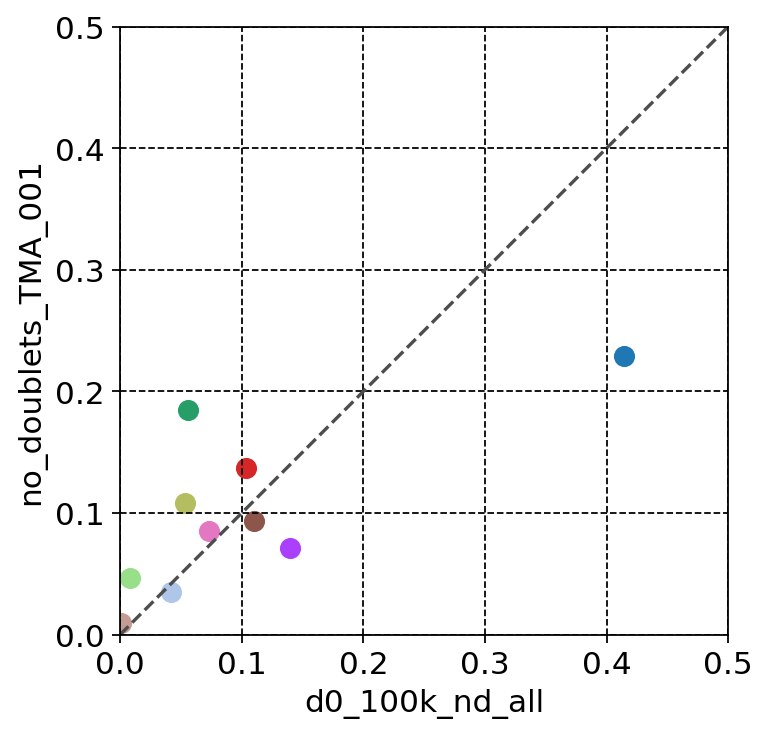

In [1652]:
# d0_100k_nd_all_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_100k_nd_all_proportions
y=no_doublets_TMA_001
xlabel='d0_100k_nd_all'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


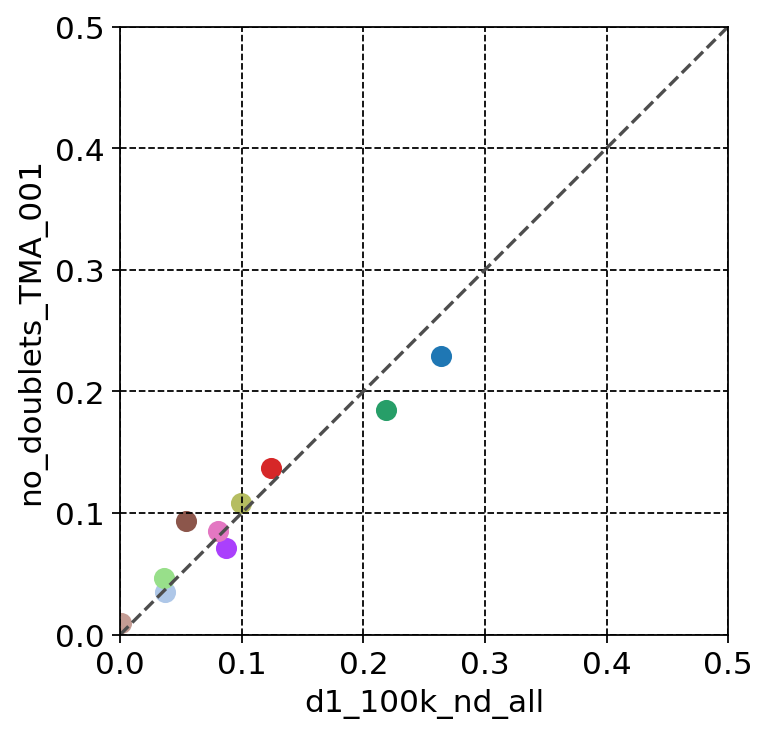

In [1653]:
# d1_100k_nd_all_proportions, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_100k_nd_all_proportions
y=no_doublets_TMA_001
xlabel='d1_100k_nd_all'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[2])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[4])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[5])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[6])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[7])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[9])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[11])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[14])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

In [1654]:
#200k

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


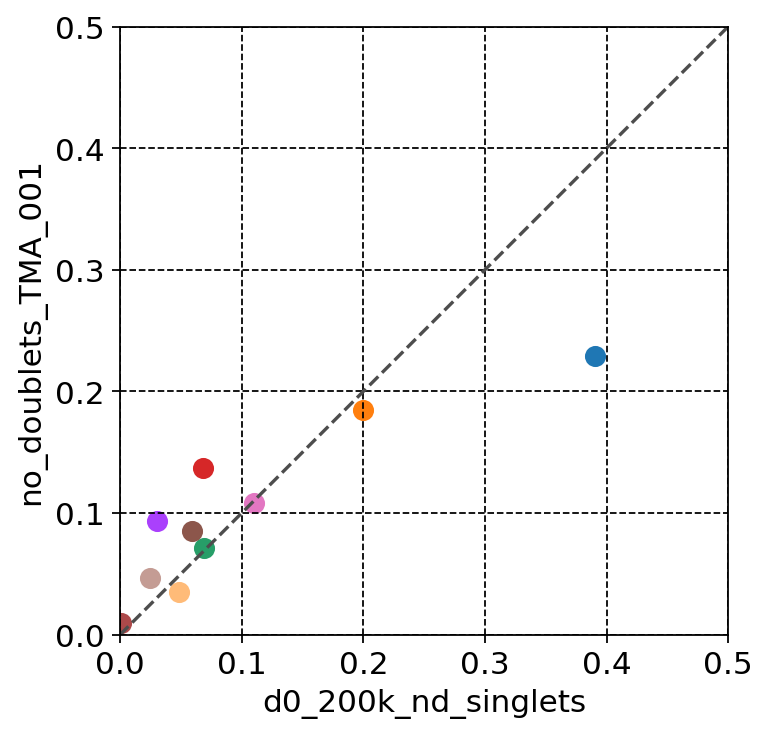

In [1655]:
# d0_200k_sng, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_200k_nd_sng_proportions
y=no_doublets_TMA_001
xlabel='d0_200k_nd_singlets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


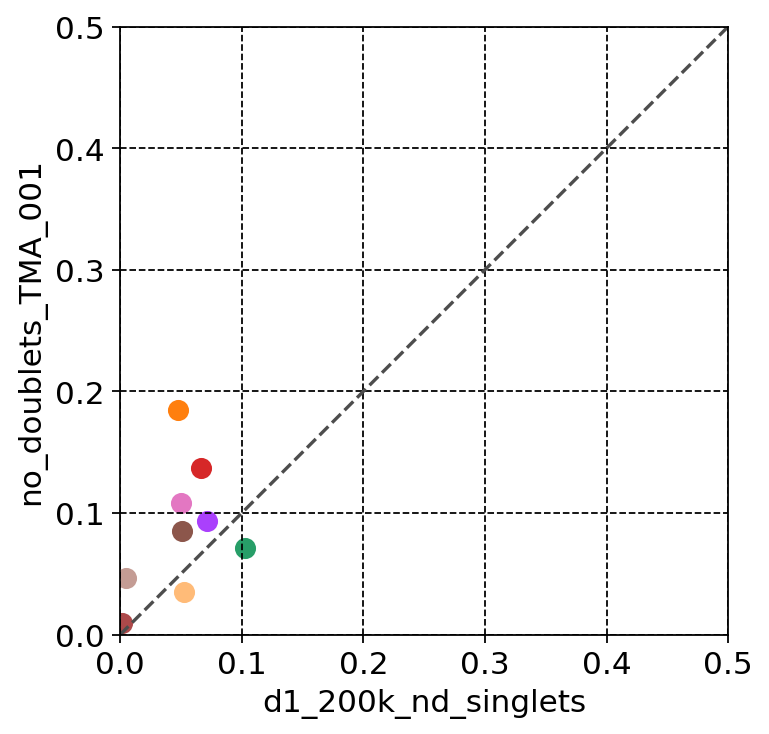

In [1656]:
# d1_200k_sng, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_200k_nd_sng_proportions
y=no_doublets_TMA_001
xlabel='d1_200k_nd_singlets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


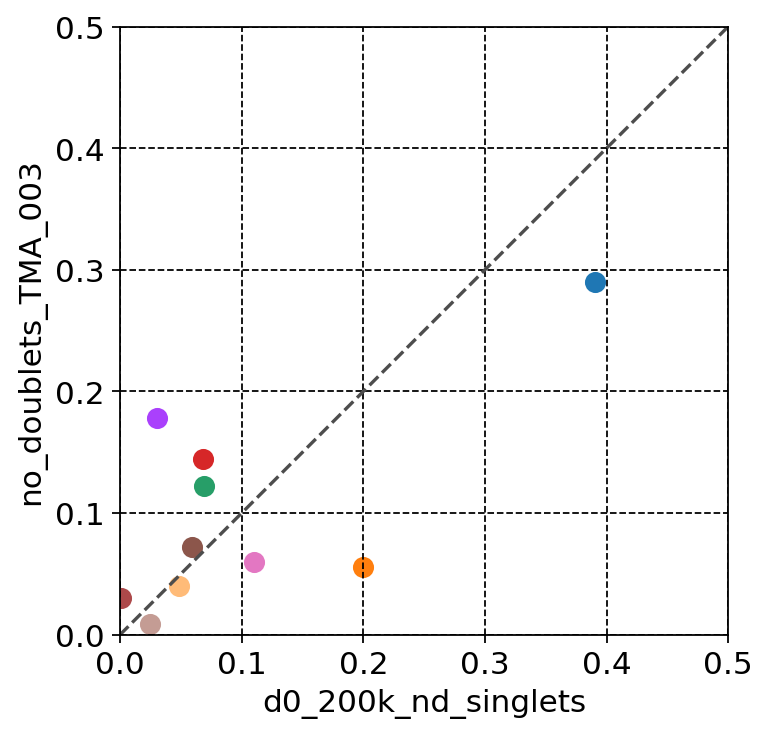

In [1657]:
# d0_200k_sng, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_200k_nd_sng_proportions
y=no_doublets_TMA_003
xlabel='d0_200k_nd_singlets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


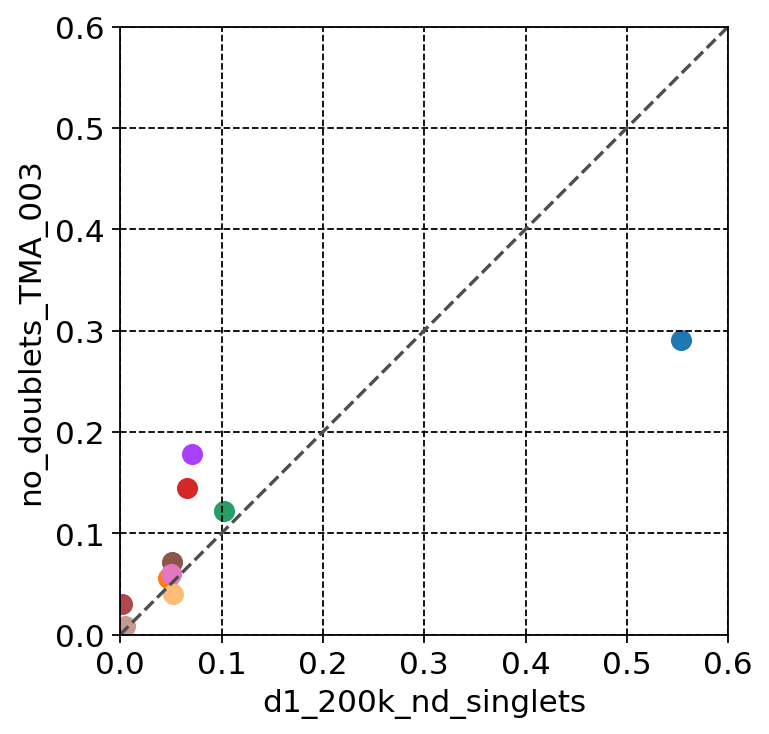

In [1658]:
# d1_200k_sng, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_200k_nd_sng_proportions
y=no_doublets_TMA_003
xlabel='d1_200k_nd_singlets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.6))
ax.set_ylim((0,.6))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


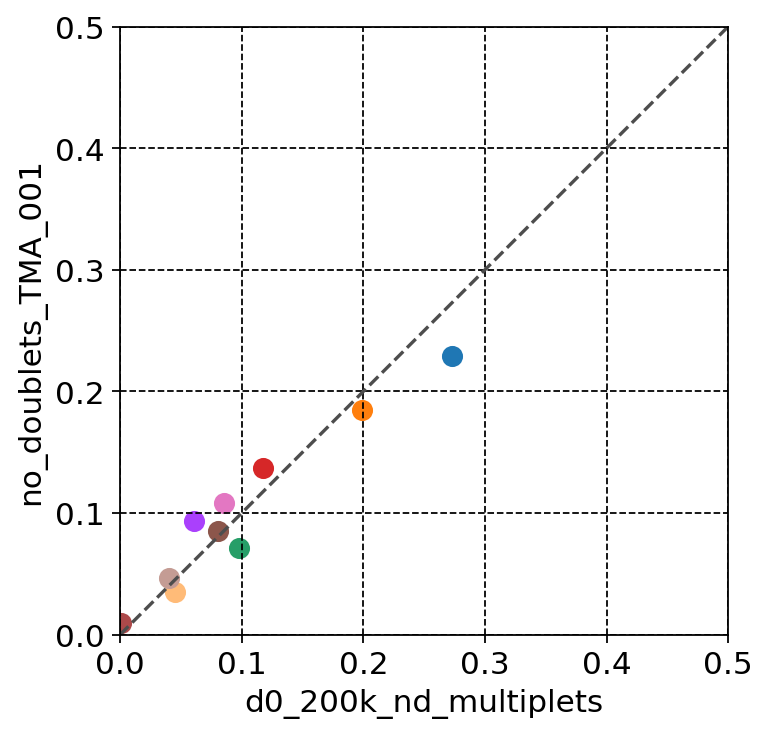

In [1659]:
# d0_200k_mpl, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_200k_nd_mpl_proportions
y=no_doublets_TMA_001
xlabel='d0_200k_nd_multiplets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


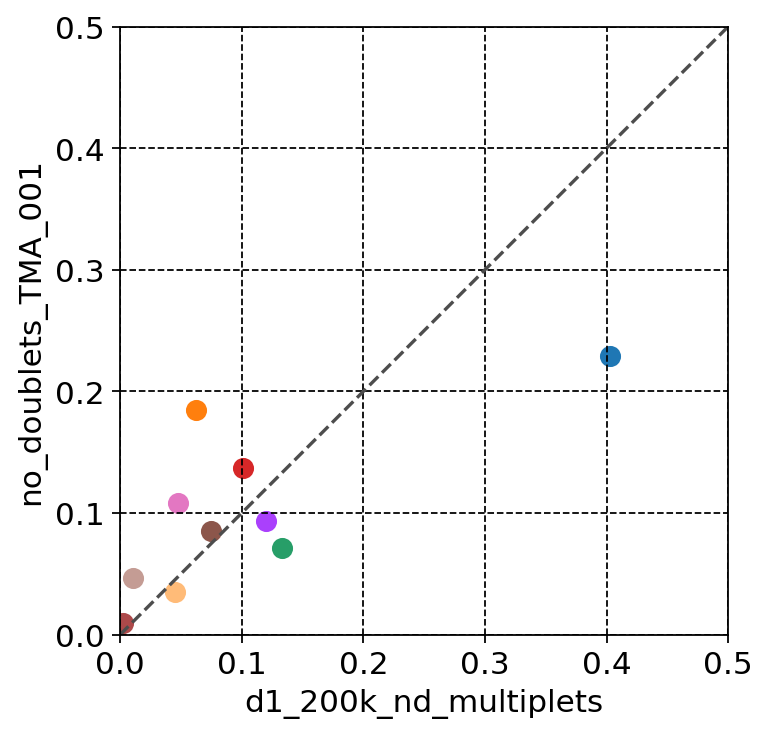

In [1660]:
# d1_200k_mpl, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_200k_nd_mpl_proportions
y=no_doublets_TMA_001
xlabel='d1_200k_nd_multiplets'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


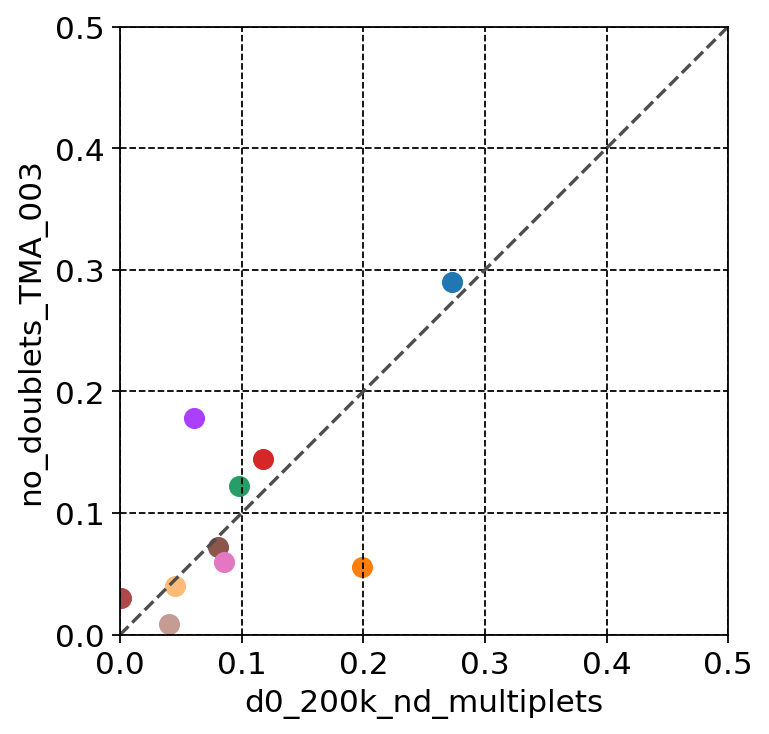

In [1661]:
# d0_200k_mpl, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_200k_nd_mpl_proportions
y=no_doublets_TMA_003
xlabel='d0_200k_nd_multiplets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


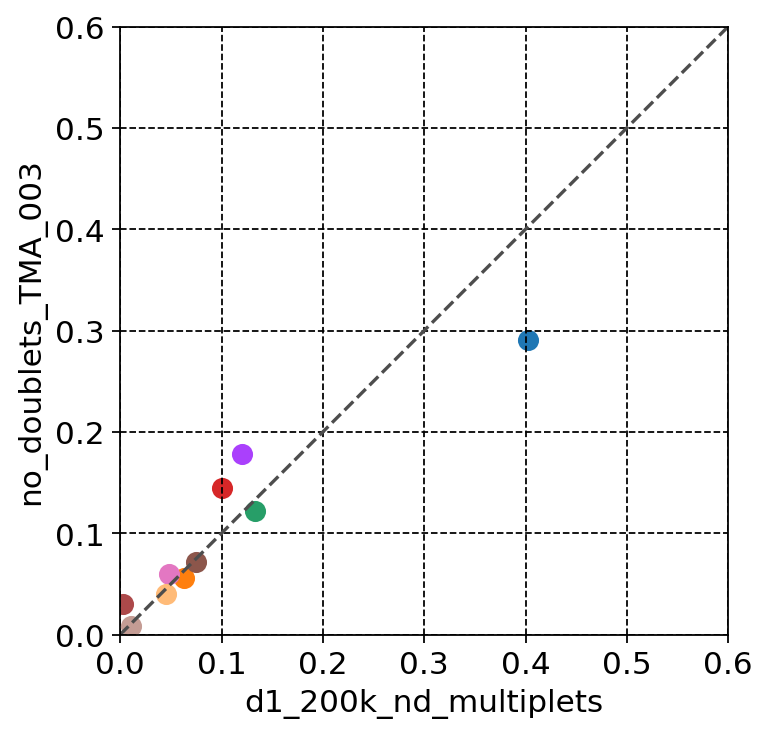

In [1662]:
# d1_200k_mpl, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_200k_nd_mpl_proportions
y=no_doublets_TMA_003
xlabel='d1_200k_nd_multiplets'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.6))
ax.set_ylim((0,.6))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


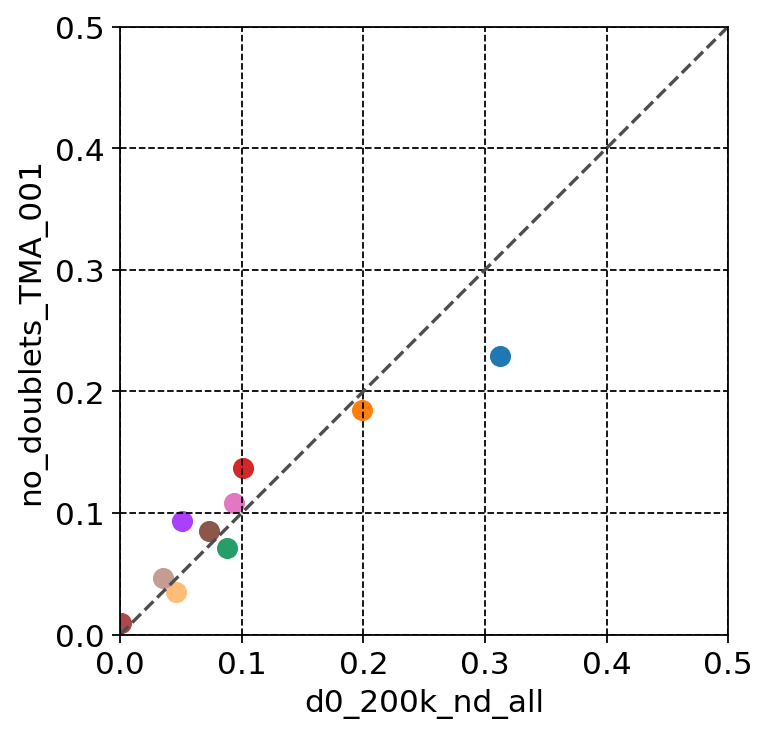

In [1663]:
# d0_200k_all, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d0_200k_nd_all_proportions
y=no_doublets_TMA_001
xlabel='d0_200k_nd_all'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


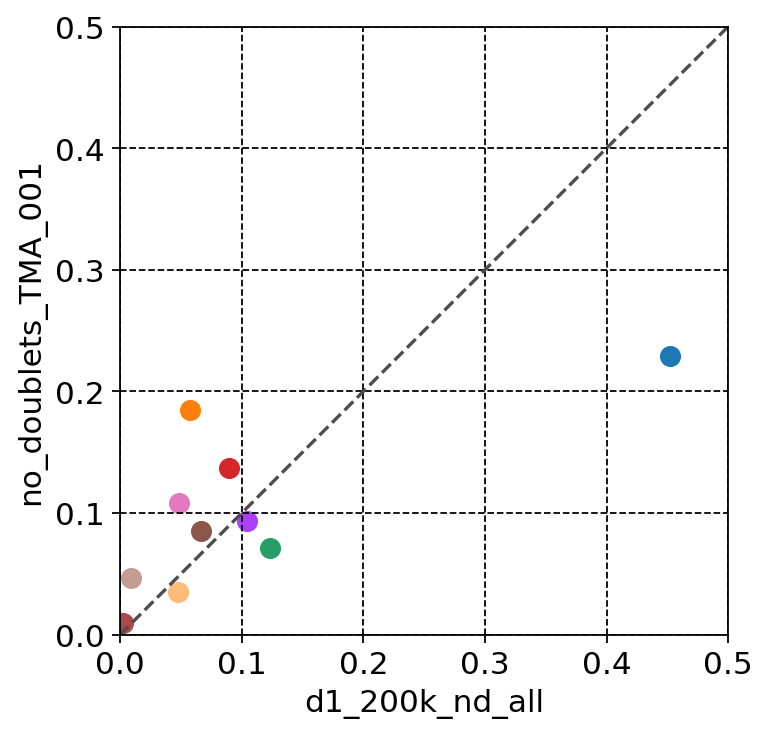

In [1664]:
# d1_200k_all, no_doublets_TMA_001
fig, ax = plt.subplots()

x=d1_200k_nd_all_proportions
y=no_doublets_TMA_001
xlabel='d1_200k_nd_all'
ylabel='no_doublets_TMA_001'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


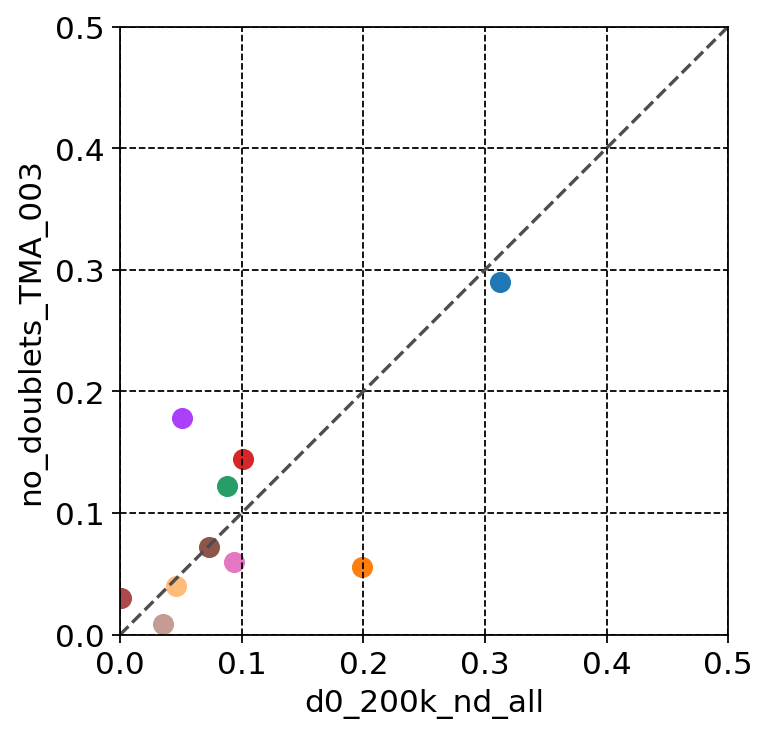

In [1665]:
# d0_200k_all, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d0_200k_nd_all_proportions
y=no_doublets_TMA_003
xlabel='d0_200k_nd_all'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.5))
ax.set_ylim((0,.5))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

/wynton/group/ye/david/Cyto-seq/200204/200221
/wynton/group/ye/david/Cyto-seq/200204


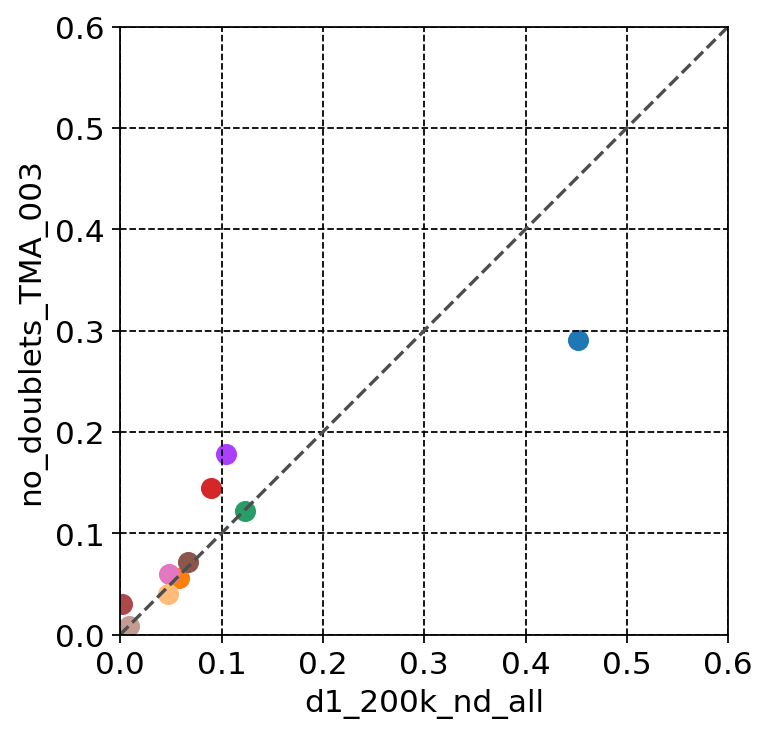

In [1671]:
# d1_200k_all, no_doublets_TMA_003
fig, ax = plt.subplots()

x=d1_200k_nd_all_proportions
y=no_doublets_TMA_003
xlabel='d1_200k_nd_all'
ylabel='no_doublets_TMA_003'

colors = vega_20_scanpy[0:20]
CD14 = plt.scatter(x[0], y[0], marker='o', s=72, color=colors[0])
CD8_naive = plt.scatter(x[1], y[1], marker='o', s=72, color=colors[1])
CD4_naive  = plt.scatter(x[2], y[2], marker='o', s=72, color=colors[3])
CD4_mem  = plt.scatter(x[3], y[3], marker='o', s=72, color=colors[2])
B  = plt.scatter(x[4], y[4], marker='o', s=72, color=colors[4])
CD8_mem = plt.scatter(x[5], y[5], marker='o', s=72, color=colors[5])
NK = plt.scatter(x[6], y[6], marker='o', s=72, color=colors[6])
cDC = plt.scatter(x[7], y[7], marker='o', s=72, color=colors[10])
gd  = plt.scatter(x[8], y[8], marker='o', s=72, color=colors[14])
rbc  = plt.scatter(x[9], y[9], marker='o', s=72, color=colors[18])


ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel) 
ax.plot([-1,1],[-1,1],ls="--", c=".3")
ax.set_xlim((0,.6))
ax.set_ylim((0,.6))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')

%cd "200221"
fig.savefig((xlabel+'_'+ylabel+'_correlation_no_legend'), dpi=600)
%cd "/wynton/group/ye/david/Cyto-seq/200204"

In [1473]:
stats.pearsonr(d0_100k_sng_proportions, d0_100k_mpl_proportions)

(0.9679387198419189, 1.0574778661432174e-06)

In [1474]:
stats.pearsonr(d1_100k_sng_proportions, d1_100k_mpl_proportions)

(0.9605341078825341, 2.6649516143078087e-06)

In [1471]:
stats.pearsonr(d0_200k_nd_sng_proportions, d0_200k_nd_mpl_proportions)

(0.9523803713819817, 2.123665141320639e-05)

In [1472]:
stats.pearsonr(d1_200k_nd_sng_proportions, d1_200k_nd_mpl_proportions)

(0.9761813475052153, 1.3682931549546754e-06)

In [1678]:
stats.pearsonr(d0_100k_nd_sng_proportions, d1_100k_nd_mpl_proportions)

(0.7610241484626306, 0.01057061607549112)

In [1679]:
stats.pearsonr(d1_100k_nd_sng_proportions, d0_100k_nd_mpl_proportions)

(0.6898755354014453, 0.0272683467755944)

In [1680]:
stats.pearsonr(d0_200k_nd_sng_proportions, d1_200k_nd_mpl_proportions)

(0.8474142727684165, 0.001964324704221659)

In [1681]:
stats.pearsonr(d1_200k_nd_sng_proportions, d0_200k_nd_mpl_proportions)

(0.7951486963913644, 0.0059673353564101556)

In [1508]:
stats.pearsonr(d0_100k_nd_all_proportions, no_doublets_TMA_003)

(0.9296772060557138, 9.822766175352411e-05)

In [1509]:
stats.pearsonr(d0_100k_nd_sng_proportions, no_doublets_TMA_003)

(0.9020041010920019, 0.00035793278542628563)

In [1510]:
stats.pearsonr(d0_100k_nd_mpl_proportions, no_doublets_TMA_003)

(0.9567820058076739, 1.4485488518414837e-05)

In [1511]:
stats.pearsonr(d0_100k_nd_all_proportions, no_doublets_TMA_001)

(0.734762413764754, 0.015493976481920253)

In [1512]:
stats.pearsonr(d0_100k_nd_sng_proportions, no_doublets_TMA_001)

(0.7333373317165953, 0.015799732523203196)

In [1513]:
stats.pearsonr(d0_100k_nd_mpl_proportions, no_doublets_TMA_001)

(0.7282379324173338, 0.016928241907098022)

In [1514]:
stats.pearsonr(d1_100k_nd_all_proportions, no_doublets_TMA_001)

(0.9745153064336242, 1.789583186352674e-06)

In [1515]:
stats.pearsonr(d1_100k_nd_sng_proportions, no_doublets_TMA_001)

(0.9615783110696524, 9.101606346097927e-06)

In [1516]:
stats.pearsonr(d1_100k_nd_mpl_proportions, no_doublets_TMA_001)

(0.9862646658517091, 1.5316469823750176e-07)

In [1517]:
stats.pearsonr(d1_100k_nd_all_proportions, no_doublets_TMA_003)

(0.6290232685894709, 0.051374962514775205)

In [1518]:
stats.pearsonr(d1_100k_nd_sng_proportions, no_doublets_TMA_003)

(0.5931744690316623, 0.0706775221116142)

In [1519]:
stats.pearsonr(d1_100k_nd_mpl_proportions, no_doublets_TMA_003)

(0.6768441160471377, 0.031586075201610685)

In [1520]:
stats.pearsonr(d0_200k_nd_all_proportions, no_doublets_TMA_003)

(0.6958927828628164, 0.02541841940967761)

In [1521]:
stats.pearsonr(d0_200k_nd_sng_proportions, no_doublets_TMA_003)

(0.6823870505684501, 0.029696575917847294)

In [1522]:
stats.pearsonr(d0_200k_nd_mpl_proportions, no_doublets_TMA_003)

(0.6916867012596659, 0.026702148850584768)

In [1526]:
stats.pearsonr(d0_200k_nd_all_proportions, no_doublets_TMA_001)

(0.943117349015296, 4.2750362705678286e-05)

In [1527]:
stats.pearsonr(d0_200k_nd_sng_proportions, no_doublets_TMA_001)

(0.889577853381249, 0.000568149483465889)

In [1528]:
stats.pearsonr(d0_200k_nd_mpl_proportions, no_doublets_TMA_001)

(0.9631398050478251, 7.72445594407264e-06)

In [1523]:
stats.pearsonr(d1_200k_nd_all_proportions, no_doublets_TMA_001)

(0.7313822358520884, 0.016226005460066622)

In [1524]:
stats.pearsonr(d1_200k_nd_sng_proportions, no_doublets_TMA_001)

(0.7090967876349327, 0.021664342941098338)

In [1525]:
stats.pearsonr(d1_200k_nd_mpl_proportions, no_doublets_TMA_001)

(0.7396788626421993, 0.014470777927109633)

In [1529]:
stats.pearsonr(d1_200k_nd_all_proportions, no_doublets_TMA_003)

(0.9084635470795649, 0.00027468389840503137)

In [1530]:
stats.pearsonr(d1_200k_nd_sng_proportions, no_doublets_TMA_003)

(0.8558160679683884, 0.00158290124786606)

In [1531]:
stats.pearsonr(d1_200k_nd_mpl_proportions, no_doublets_TMA_003)

(0.9360771591040772, 6.759162218272977e-05)

In [1722]:
#all clusters proportions

In [ ]:
c0 = d0_200k_all[(d0_200k_all.obs['leiden']=='0')].shape[0]/(d0_200k_all.obs.shape[0])

In [ ]:
sc.pl.umap(no_demux_doublets_100k, color = 'leiden')

In [ ]:
sc.pl.umap(no_demux_doublets_200k, color = 'leiden')

In [1741]:
d0_100k_nd_all_c = no_demux_doublets_100k[no_demux_doublets_100k.obs['Demuxlet']=='donor0']
d1_100k_nd_all_c = no_demux_doublets_100k[no_demux_doublets_100k.obs['Demuxlet']=='donor1']

In [1735]:
d0_100k_nd_sng_c = no_demux_doublets_100k[(no_demux_doublets_100k.obs['Type']=='Singlet')&(no_demux_doublets_100k.obs['Demuxlet']=='donor0')]
d0_100k_nd_mpl_c = no_demux_doublets_100k[(no_demux_doublets_100k.obs['Type']=='Doublet')&(no_demux_doublets_100k.obs['Demuxlet']=='donor0')]

In [1736]:
d1_100k_nd_sng_c = no_demux_doublets_100k[(no_demux_doublets_100k.obs['Type']=='Singlet')&(no_demux_doublets_100k.obs['Demuxlet']=='donor1')]
d1_100k_nd_mpl_c = no_demux_doublets_100k[(no_demux_doublets_100k.obs['Type']=='Doublet')&(no_demux_doublets_100k.obs['Demuxlet']=='donor1')]

In [1737]:
d0_200k_nd_all_c = no_demux_doublets_200k[no_demux_doublets_200k.obs['Demuxlet']=='donor0']
d1_200k_nd_all_c = no_demux_doublets_200k[no_demux_doublets_200k.obs['Demuxlet']=='donor1']

In [1738]:
d0_200k_nd_sng_c = no_demux_doublets_200k[(no_demux_doublets_200k.obs['Type']=='Singlet')&(no_demux_doublets_200k.obs['Demuxlet']=='donor0')]
d0_200k_nd_mpl_c = no_demux_doublets_200k[(no_demux_doublets_200k.obs['Type']=='Doublet')&(no_demux_doublets_200k.obs['Demuxlet']=='donor0')]

In [1739]:
d1_200k_nd_sng_c = no_demux_doublets_200k[(no_demux_doublets_200k.obs['Type']=='Singlet')&(no_demux_doublets_200k.obs['Demuxlet']=='donor1')]
d1_200k_nd_mpl_c = no_demux_doublets_200k[(no_demux_doublets_200k.obs['Type']=='Doublet')&(no_demux_doublets_200k.obs['Demuxlet']=='donor1')]

In [1768]:
d0_100k_nd_all_c_proportions_c

[0.1899144112884571,
 0.17059912098080038,
 0.052914642609299095,
 0.09860050890585242,
 0.1321998612074948,
 0.10449919037705298,
 0.06904927133934767,
 0.050370113347212586,
 0.04030765671987046,
 0.0395558639833449,
 0.033021050196622714,
 0.007807078417765441,
 0.0087323617857969,
 0.0016770761045570206,
 0.000751792736525561]

In [1769]:
d1_100k_nd_all_c_proportions_c

[0.13029413526627928,
 0.10088060863835141,
 0.20853052177559456,
 0.11831306535673636,
 0.08296890912358473,
 0.05163841131012999,
 0.07679865812017013,
 0.09435092553765051,
 0.03887857185646678,
 0.03510453483496076,
 0.02012819744803211,
 0.0340262385431019,
 0.006769304498891751,
 0.0008386748936680046,
 0.00047924279638171687]

In [1770]:
d0_100k_nd_sng_c_proportions_c

[0.20867178924259056,
 0.18562019758507134,
 0.05214050493962678,
 0.10526893523600439,
 0.1353457738748628,
 0.07958287596048298,
 0.07222832052689353,
 0.05115257958287596,
 0.011855104281009879,
 0.04182217343578485,
 0.03754116355653128,
 0.007135016465422613,
 0.009440175631174533,
 0.0014270032930845224,
 0.0007683863885839736]

In [1780]:
d1_100k_nd_sng_c_proportions_c

[0.14134196717650999,
 0.10996985597856425,
 0.22931785195936139,
 0.1166685274087306,
 0.08284023668639054,
 0.039298872390309256,
 0.07491347549402702,
 0.09992184883331473,
 0.009489784526068997,
 0.035614603103717765,
 0.020207658814335158,
 0.03282349000781511,
 0.00669867143016635,
 0.000669867143016635,
 0.0002232890476722117]

In [1771]:
d0_100k_nd_mpl_c_proportions_c

[0.16902957712050842,
 0.15387435834759228,
 0.05377658274260572,
 0.09117575164996333,
 0.12869714006355415,
 0.13224150574431678,
 0.06550965534099243,
 0.049498900024443904,
 0.07198728917135175,
 0.03703251038865803,
 0.02798826692740161,
 0.008555365436323637,
 0.007944267905157664,
 0.001955512099731117,
 0.0007333170373991689]

In [1772]:
d1_100k_nd_sng_c_proportions_c

[0.14134196717650999,
 0.10996985597856425,
 0.22931785195936139,
 0.1166685274087306,
 0.08284023668639054,
 0.039298872390309256,
 0.07491347549402702,
 0.09992184883331473,
 0.009489784526068997,
 0.035614603103717765,
 0.020207658814335158,
 0.03282349000781511,
 0.00669867143016635,
 0.000669867143016635,
 0.0002232890476722117]

In [1774]:
d0_200k_nd_all_c_proportions_c 

[0.12616201859229748,
 0.1856042496679947,
 0.08212483399734395,
 0.09397078353253652,
 0.04701195219123506,
 0.06804780876494024,
 0.06055776892430279,
 0.08733067729083666,
 0.040796812749003986,
 0.042284196547144756,
 0.04308100929614874,
 0.027091633466135457,
 0.019335989375830014,
 0.02395750332005312,
 0.03266932270916335,
 0.012642762284196547,
 0.004887118193891102,
 0.001752988047808765,
 0.0006905710491367862]

In [1775]:
d1_200k_nd_all_c_proportions_c

[0.1864652918966018,
 0.053296543711879175,
 0.11409623390454061,
 0.08287346306515636,
 0.09642753412721464,
 0.061719430729015395,
 0.08447090715461322,
 0.044970471488043375,
 0.05866976474005228,
 0.042017620292380674,
 0.04390550876173879,
 0.037322102817310486,
 0.019217736470132637,
 0.033449511085293836,
 0.00813244263723497,
 0.018249588537128474,
 0.0069706651176299735,
 0.00576048020137477,
 0.0019847032626585342]

In [1776]:
d0_200k_nd_sng_c_proportions_c

[0.15874046421035545,
 0.19120272683006007,
 0.06622301574419737,
 0.06541145917870475,
 0.02889141373153709,
 0.056159714332088946,
 0.07872098685278364,
 0.10566466482713845,
 0.0501541957474436,
 0.01639344262295082,
 0.045934101606882,
 0.037493913325758806,
 0.019964291511118323,
 0.031650706054211976,
 0.023697451712384354,
 0.017367310501541958,
 0.004057782827463074,
 0.0019477357571822756,
 0.00032462262619704593]

In [1778]:
d1_200k_nd_sng_c_proportions_c

[0.22798241624981053,
 0.04517204790056086,
 0.09807488252235864,
 0.06336213430347128,
 0.06790965590419888,
 0.04850689707442777,
 0.11141427921782629,
 0.047748976807639835,
 0.07245717750492649,
 0.01409731696225557,
 0.04987115355464605,
 0.048355313021070184,
 0.020767015309989388,
 0.04426254358041534,
 0.00424435349401243,
 0.02349552827042595,
 0.005457025920873124,
 0.005305441867515537,
 0.0015158405335758678]

In [1777]:
d0_200k_nd_mpl_c_proportions_c

[0.11031269740998105,
 0.18288060644346177,
 0.08986102337334176,
 0.1078648136449779,
 0.05582754264055591,
 0.07383133291219204,
 0.05172141503474416,
 0.07841124447252053,
 0.03624447252053064,
 0.054879974731522424,
 0.041692987997473153,
 0.022030953885028428,
 0.01903032217308907,
 0.02021478205938092,
 0.0370341124447252,
 0.010344283006948831,
 0.005290587492103601,
 0.0016582438408085914,
 0.000868603916614024]

In [1781]:
d1_200k_nd_mpl_c_proportions_c

[0.16698670080364128,
 0.05710831377569163,
 0.12161297205035204,
 0.09202759405447693,
 0.10980726833084418,
 0.06791835573572293,
 0.07182988407652371,
 0.04366688002275798,
 0.05220112367541427,
 0.055116990256738496,
 0.041106606926961095,
 0.032145651091672,
 0.01849086124742195,
 0.02837636014508214,
 0.009956617594765665,
 0.015788350757414124,
 0.007680819287390655,
 0.005973970556859398,
 0.00220467961026954]

In [1779]:
d1_200k_nd_mpl_c_proportions_c

[0.16698670080364128,
 0.05710831377569163,
 0.12161297205035204,
 0.09202759405447693,
 0.10980726833084418,
 0.06791835573572293,
 0.07182988407652371,
 0.04366688002275798,
 0.05220112367541427,
 0.055116990256738496,
 0.041106606926961095,
 0.032145651091672,
 0.01849086124742195,
 0.02837636014508214,
 0.009956617594765665,
 0.015788350757414124,
 0.007680819287390655,
 0.005973970556859398,
 0.00220467961026954]

In [1745]:
#d0 100k_nd all_c
c0 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='0')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c1 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='1')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c2 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='2')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c3 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='3')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c4 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='4')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c5 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='5')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c6 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='6')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c7 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='7')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c8 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='8')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c9 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='9')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c10 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='10')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c11 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='11')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c12 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='12')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c13 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='13')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])
c14 = d0_100k_nd_all_c[(d0_100k_nd_all_c.obs['leiden']=='14')].shape[0]/(d0_100k_nd_all_c.obs.shape[0])

d0_100k_nd_all_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d0_100k_nd_all_c_proportions_c)



1.0

In [1748]:
#d1 100k_nd all_c
c0 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='0')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c1 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='1')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c2 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='2')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c3 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='3')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c4 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='4')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c5 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='5')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c6 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='6')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c7 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='7')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c8 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='8')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c9 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='9')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c10 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='10')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c11 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='11')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c12 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='12')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c13 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='13')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])
c14 = d1_100k_nd_all_c[(d1_100k_nd_all_c.obs['leiden']=='14')].shape[0]/(d1_100k_nd_all_c.obs.shape[0])

d1_100k_nd_all_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d1_100k_nd_all_c_proportions_c)



1.0

In [1749]:
#d0 100k_nd sng_c
c0 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='0')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c1 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='1')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c2 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='2')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c3 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='3')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c4 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='4')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c5 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='5')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c6 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='6')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c7 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='7')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c8 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='8')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c9 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='9')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c10 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='10')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c11 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='11')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c12 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='12')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c13 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='13')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])
c14 = d0_100k_nd_sng_c[(d0_100k_nd_sng_c.obs['leiden']=='14')].shape[0]/(d0_100k_nd_sng_c.obs.shape[0])

d0_100k_nd_sng_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d0_100k_nd_sng_c_proportions_c)



1.0

In [1750]:
#d1 100k_nd sng_c
c0 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='0')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c1 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='1')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c2 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='2')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c3 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='3')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c4 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='4')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c5 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='5')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c6 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='6')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c7 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='7')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c8 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='8')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c9 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='9')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c10 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='10')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c11 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='11')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c12 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='12')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c13 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='13')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])
c14 = d1_100k_nd_sng_c[(d1_100k_nd_sng_c.obs['leiden']=='14')].shape[0]/(d1_100k_nd_sng_c.obs.shape[0])

d1_100k_nd_sng_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d1_100k_nd_sng_c_proportions_c)



1.0

In [1751]:
#d0 100k_nd mpl_c
c0 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='0')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c1 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='1')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c2 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='2')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c3 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='3')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c4 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='4')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c5 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='5')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c6 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='6')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c7 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='7')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c8 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='8')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c9 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='9')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c10 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='10')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c11 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='11')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c12 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='12')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c13 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='13')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])
c14 = d0_100k_nd_mpl_c[(d0_100k_nd_mpl_c.obs['leiden']=='14')].shape[0]/(d0_100k_nd_mpl_c.obs.shape[0])

d0_100k_nd_mpl_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d0_100k_nd_mpl_c_proportions_c)



1.0

In [1754]:
#d1 200k_nd mpl_c
c0 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='0')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c1 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='1')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c2 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='2')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c3 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='3')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c4 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='4')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c5 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='5')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c6 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='6')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c7 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='7')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c8 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='8')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c9 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='9')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c10 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='10')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c11 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='11')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c12 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='12')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c13 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='13')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c14 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='14')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])

d1_200k_nd_mpl_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14]

np.sum(d1_200k_nd_mpl_c_proportions_c)



0.9683521797880662

In [1755]:
#200k

In [1762]:
#d0 200k_nd all_c
c0 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='0')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c1 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='1')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c2 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='2')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c3 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='3')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c4 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='4')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c5 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='5')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c6 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='6')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c7 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='7')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c8 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='8')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c9 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='9')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c10 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='10')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c11 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='11')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c12 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='12')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c13 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='13')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c14 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='14')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c15 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='15')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c16 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='16')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c17 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='17')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])
c18 = d0_200k_nd_all_c[(d0_200k_nd_all_c.obs['leiden']=='18')].shape[0]/(d0_200k_nd_all_c.obs.shape[0])



d0_200k_nd_all_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d0_200k_nd_all_c_proportions_c)



1.0

In [1763]:
#d1 200k_nd all_c
c0 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='0')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c1 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='1')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c2 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='2')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c3 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='3')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c4 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='4')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c5 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='5')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c6 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='6')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c7 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='7')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c8 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='8')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c9 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='9')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c10 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='10')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c11 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='11')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c12 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='12')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c13 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='13')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c14 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='14')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c15 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='15')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c16 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='16')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c17 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='17')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])
c18 = d1_200k_nd_all_c[(d1_200k_nd_all_c.obs['leiden']=='18')].shape[0]/(d1_200k_nd_all_c.obs.shape[0])



d1_200k_nd_all_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d1_200k_nd_all_c_proportions_c)



1.0

In [1764]:
#d0 200k_nd sng_c
c0 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='0')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c1 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='1')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c2 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='2')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c3 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='3')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c4 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='4')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c5 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='5')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c6 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='6')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c7 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='7')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c8 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='8')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c9 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='9')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c10 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='10')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c11 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='11')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c12 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='12')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c13 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='13')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c14 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='14')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c15 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='15')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c16 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='16')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c17 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='17')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])
c18 = d0_200k_nd_sng_c[(d0_200k_nd_sng_c.obs['leiden']=='18')].shape[0]/(d0_200k_nd_sng_c.obs.shape[0])



d0_200k_nd_sng_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d0_200k_nd_sng_c_proportions_c)



1.0

In [1765]:
#d1 200k_nd sng_c
c0 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='0')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c1 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='1')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c2 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='2')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c3 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='3')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c4 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='4')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c5 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='5')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c6 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='6')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c7 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='7')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c8 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='8')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c9 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='9')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c10 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='10')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c11 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='11')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c12 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='12')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c13 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='13')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c14 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='14')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c15 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='15')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c16 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='16')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c17 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='17')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])
c18 = d1_200k_nd_sng_c[(d1_200k_nd_sng_c.obs['leiden']=='18')].shape[0]/(d1_200k_nd_sng_c.obs.shape[0])



d1_200k_nd_sng_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d1_200k_nd_sng_c_proportions_c)



1.0

In [1766]:
#d0 200k_nd mpl_c
c0 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='0')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c1 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='1')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c2 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='2')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c3 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='3')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c4 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='4')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c5 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='5')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c6 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='6')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c7 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='7')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c8 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='8')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c9 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='9')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c10 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='10')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c11 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='11')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c12 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='12')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c13 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='13')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c14 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='14')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c15 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='15')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c16 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='16')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c17 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='17')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])
c18 = d0_200k_nd_mpl_c[(d0_200k_nd_mpl_c.obs['leiden']=='18')].shape[0]/(d0_200k_nd_mpl_c.obs.shape[0])



d0_200k_nd_mpl_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d0_200k_nd_mpl_c_proportions_c)



0.9999999999999999

In [1767]:
#d1 200k_nd mpl_c
c0 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='0')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c1 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='1')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c2 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='2')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c3 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='3')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c4 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='4')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c5 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='5')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c6 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='6')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c7 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='7')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c8 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='8')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c9 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='9')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c10 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='10')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c11 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='11')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c12 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='12')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c13 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='13')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c14 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='14')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c15 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='15')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c16 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='16')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c17 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='17')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])
c18 = d1_200k_nd_mpl_c[(d1_200k_nd_mpl_c.obs['leiden']=='18')].shape[0]/(d1_200k_nd_mpl_c.obs.shape[0])



d1_200k_nd_mpl_c_proportions_c = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18]

np.sum(d1_200k_nd_mpl_c_proportions_c)



1.0

In [1783]:
d1_100k_nd_mpl_c_proportions_c

[0.11750258531540848,
 0.09035677352637021,
 0.1844622543950362,
 0.1202171664943123,
 0.08311789038262668,
 0.06592554291623579,
 0.07898138572905894,
 0.08790072388831438,
 0.07290589451913133,
 0.03451396070320579,
 0.020036194415718717,
 0.03541882109617373,
 0.006851085832471561,
 0.001034126163391934,
 0.0007755946225439503]